# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

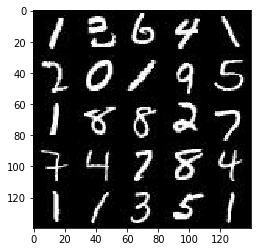

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

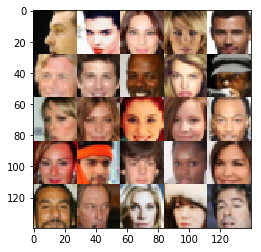

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).

## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.13.1


/home/thiagojv/anaconda3/envs/dog-project/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='lr', shape=())

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.9):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        drop1 = tf.nn.dropout(relu1, rate=0.2)
        # 14x14x64
        
        x2 = tf.layers.conv2d(drop1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.nn.dropout(relu2, rate=0.2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(drop2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.nn.dropout(relu3, rate=0.2)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(drop3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.dense instead.
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, reuse=False, alpha=0.9):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, smooth = 0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    samples, losses = [], []
    steps = 0    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Normalizing batch_images from range [-0.5, 0.5] to [-1, 1]
                batch_images = batch_images / 0.5

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={
                    input_real: batch_images, 
                    input_z: batch_z, 
                    lr: learning_rate
                })
                _ = sess.run(g_opt, feed_dict={
                    input_real: batch_images, 
                    input_z: batch_z, 
                    lr: learning_rate
                })
                
                if steps == 1:
                    print('initial output:')
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Generator Loss: {:.4f}".format(train_loss_g),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output:


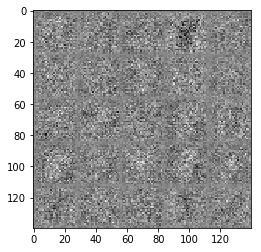

Epoch 1/2... Generator Loss: 0.1434 Discriminator Loss: 4.0865...
Epoch 1/2... Generator Loss: 0.6369 Discriminator Loss: 1.9335...
Epoch 1/2... Generator Loss: 1.7652 Discriminator Loss: 1.0197...
Epoch 1/2... Generator Loss: 2.9398 Discriminator Loss: 0.5973...
Epoch 1/2... Generator Loss: 2.1759 Discriminator Loss: 1.5271...
Epoch 1/2... Generator Loss: 3.9080 Discriminator Loss: 1.0393...
Epoch 1/2... Generator Loss: 2.8626 Discriminator Loss: 1.0947...
Epoch 1/2... Generator Loss: 0.7792 Discriminator Loss: 2.3871...
Epoch 1/2... Generator Loss: 0.6868 Discriminator Loss: 2.7302...
Epoch 1/2... Generator Loss: 0.5318 Discriminator Loss: 2.0325...


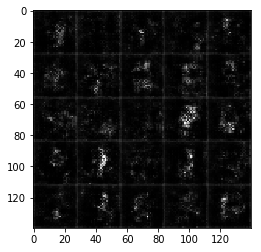

Epoch 1/2... Generator Loss: 0.1687 Discriminator Loss: 2.6785...
Epoch 1/2... Generator Loss: 0.8985 Discriminator Loss: 1.6060...
Epoch 1/2... Generator Loss: 0.3106 Discriminator Loss: 2.0470...
Epoch 1/2... Generator Loss: 0.3699 Discriminator Loss: 1.8434...
Epoch 1/2... Generator Loss: 0.5080 Discriminator Loss: 1.6857...
Epoch 1/2... Generator Loss: 0.5972 Discriminator Loss: 1.7257...
Epoch 1/2... Generator Loss: 0.5422 Discriminator Loss: 1.6744...
Epoch 1/2... Generator Loss: 1.0208 Discriminator Loss: 1.6912...
Epoch 1/2... Generator Loss: 0.5223 Discriminator Loss: 1.5391...
Epoch 1/2... Generator Loss: 0.7979 Discriminator Loss: 1.5529...


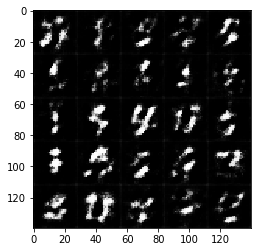

Epoch 1/2... Generator Loss: 1.0239 Discriminator Loss: 1.4350...
Epoch 1/2... Generator Loss: 0.8461 Discriminator Loss: 1.4960...
Epoch 1/2... Generator Loss: 1.5185 Discriminator Loss: 1.6068...
Epoch 1/2... Generator Loss: 0.8866 Discriminator Loss: 1.6621...
Epoch 1/2... Generator Loss: 0.6920 Discriminator Loss: 1.4729...
Epoch 1/2... Generator Loss: 0.9248 Discriminator Loss: 1.6078...
Epoch 1/2... Generator Loss: 1.4143 Discriminator Loss: 1.6499...
Epoch 1/2... Generator Loss: 0.5445 Discriminator Loss: 1.6241...
Epoch 1/2... Generator Loss: 0.5216 Discriminator Loss: 1.6161...
Epoch 1/2... Generator Loss: 0.7357 Discriminator Loss: 1.3732...


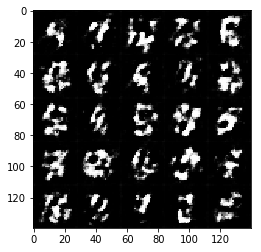

Epoch 1/2... Generator Loss: 0.5310 Discriminator Loss: 1.5613...
Epoch 1/2... Generator Loss: 0.7196 Discriminator Loss: 1.5374...
Epoch 1/2... Generator Loss: 1.1210 Discriminator Loss: 1.6453...
Epoch 1/2... Generator Loss: 0.7279 Discriminator Loss: 1.5279...
Epoch 1/2... Generator Loss: 0.5505 Discriminator Loss: 1.5169...
Epoch 1/2... Generator Loss: 0.4186 Discriminator Loss: 1.7753...
Epoch 1/2... Generator Loss: 0.7386 Discriminator Loss: 1.5777...
Epoch 1/2... Generator Loss: 0.7602 Discriminator Loss: 1.5790...
Epoch 1/2... Generator Loss: 0.7061 Discriminator Loss: 1.4351...
Epoch 1/2... Generator Loss: 0.5789 Discriminator Loss: 1.5612...


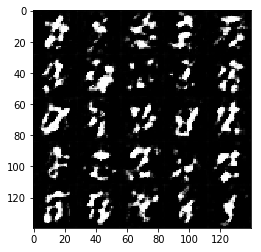

Epoch 1/2... Generator Loss: 0.6866 Discriminator Loss: 1.4693...
Epoch 1/2... Generator Loss: 0.4994 Discriminator Loss: 1.6291...
Epoch 1/2... Generator Loss: 0.6606 Discriminator Loss: 1.4791...
Epoch 1/2... Generator Loss: 0.6343 Discriminator Loss: 1.4676...
Epoch 1/2... Generator Loss: 0.8559 Discriminator Loss: 1.4527...
Epoch 1/2... Generator Loss: 0.5530 Discriminator Loss: 1.4259...
Epoch 1/2... Generator Loss: 0.6035 Discriminator Loss: 1.5274...
Epoch 1/2... Generator Loss: 1.1311 Discriminator Loss: 1.6005...
Epoch 1/2... Generator Loss: 0.6565 Discriminator Loss: 1.5122...
Epoch 1/2... Generator Loss: 0.6829 Discriminator Loss: 1.5870...


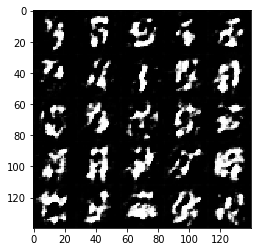

Epoch 1/2... Generator Loss: 0.5099 Discriminator Loss: 1.4998...
Epoch 1/2... Generator Loss: 1.2699 Discriminator Loss: 1.4144...
Epoch 1/2... Generator Loss: 0.5091 Discriminator Loss: 1.5379...
Epoch 1/2... Generator Loss: 0.8711 Discriminator Loss: 1.5043...
Epoch 1/2... Generator Loss: 0.7321 Discriminator Loss: 1.5276...
Epoch 1/2... Generator Loss: 1.0181 Discriminator Loss: 1.5666...
Epoch 1/2... Generator Loss: 0.5249 Discriminator Loss: 1.5014...
Epoch 1/2... Generator Loss: 1.0175 Discriminator Loss: 1.4032...
Epoch 1/2... Generator Loss: 0.6419 Discriminator Loss: 1.4399...
Epoch 1/2... Generator Loss: 0.3779 Discriminator Loss: 1.7247...


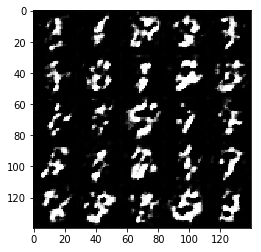

Epoch 1/2... Generator Loss: 1.0013 Discriminator Loss: 1.5713...
Epoch 1/2... Generator Loss: 0.5327 Discriminator Loss: 1.5618...
Epoch 1/2... Generator Loss: 0.5862 Discriminator Loss: 1.4207...
Epoch 1/2... Generator Loss: 0.6753 Discriminator Loss: 1.5309...
Epoch 1/2... Generator Loss: 0.8297 Discriminator Loss: 1.4647...
Epoch 1/2... Generator Loss: 0.8638 Discriminator Loss: 1.3642...
Epoch 1/2... Generator Loss: 0.9013 Discriminator Loss: 1.4302...
Epoch 1/2... Generator Loss: 1.1792 Discriminator Loss: 1.6129...
Epoch 1/2... Generator Loss: 0.7351 Discriminator Loss: 1.3358...
Epoch 1/2... Generator Loss: 0.7904 Discriminator Loss: 1.5884...


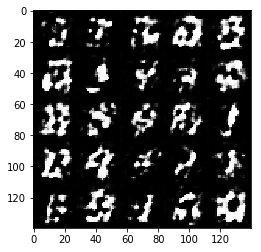

Epoch 1/2... Generator Loss: 1.2058 Discriminator Loss: 1.5701...
Epoch 1/2... Generator Loss: 0.8618 Discriminator Loss: 1.3185...
Epoch 1/2... Generator Loss: 1.2428 Discriminator Loss: 1.5927...
Epoch 1/2... Generator Loss: 0.8540 Discriminator Loss: 1.4719...
Epoch 1/2... Generator Loss: 0.7475 Discriminator Loss: 1.3204...
Epoch 1/2... Generator Loss: 0.5900 Discriminator Loss: 1.4268...
Epoch 1/2... Generator Loss: 0.5252 Discriminator Loss: 1.5861...
Epoch 1/2... Generator Loss: 0.6148 Discriminator Loss: 1.4867...
Epoch 1/2... Generator Loss: 0.6591 Discriminator Loss: 1.4867...
Epoch 1/2... Generator Loss: 0.8127 Discriminator Loss: 1.4458...


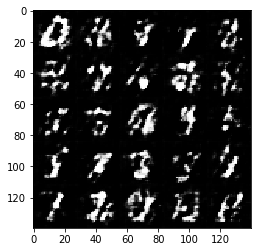

Epoch 1/2... Generator Loss: 0.5301 Discriminator Loss: 1.5446...
Epoch 1/2... Generator Loss: 0.8569 Discriminator Loss: 1.4983...
Epoch 1/2... Generator Loss: 1.0196 Discriminator Loss: 1.4251...
Epoch 1/2... Generator Loss: 1.2351 Discriminator Loss: 1.6612...
Epoch 1/2... Generator Loss: 0.6078 Discriminator Loss: 1.6103...
Epoch 1/2... Generator Loss: 1.0818 Discriminator Loss: 1.4677...
Epoch 1/2... Generator Loss: 1.1218 Discriminator Loss: 1.4504...
Epoch 1/2... Generator Loss: 0.6795 Discriminator Loss: 1.3974...
Epoch 1/2... Generator Loss: 1.1071 Discriminator Loss: 1.5405...
Epoch 1/2... Generator Loss: 0.6288 Discriminator Loss: 1.5441...


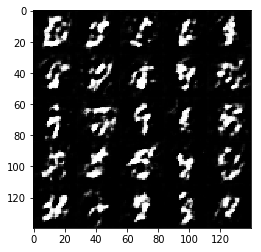

Epoch 1/2... Generator Loss: 0.7309 Discriminator Loss: 1.3784...
Epoch 1/2... Generator Loss: 0.6319 Discriminator Loss: 1.5025...
Epoch 1/2... Generator Loss: 0.9677 Discriminator Loss: 1.4415...
Epoch 1/2... Generator Loss: 1.0310 Discriminator Loss: 1.5074...
Epoch 1/2... Generator Loss: 0.8244 Discriminator Loss: 1.4108...
Epoch 1/2... Generator Loss: 0.6470 Discriminator Loss: 1.4686...
Epoch 1/2... Generator Loss: 0.9194 Discriminator Loss: 1.4224...
Epoch 1/2... Generator Loss: 0.6059 Discriminator Loss: 1.5195...
Epoch 1/2... Generator Loss: 0.6495 Discriminator Loss: 1.5006...
Epoch 1/2... Generator Loss: 1.0709 Discriminator Loss: 1.5214...


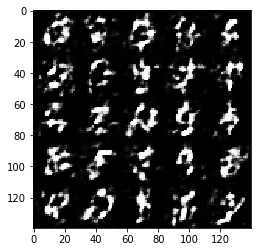

Epoch 1/2... Generator Loss: 1.3157 Discriminator Loss: 1.6682...
Epoch 1/2... Generator Loss: 0.5985 Discriminator Loss: 1.5434...
Epoch 1/2... Generator Loss: 0.7363 Discriminator Loss: 1.3760...
Epoch 1/2... Generator Loss: 0.4846 Discriminator Loss: 1.6798...
Epoch 1/2... Generator Loss: 0.9886 Discriminator Loss: 1.4533...
Epoch 1/2... Generator Loss: 0.4570 Discriminator Loss: 1.5335...
Epoch 1/2... Generator Loss: 1.2830 Discriminator Loss: 1.5660...
Epoch 1/2... Generator Loss: 0.9402 Discriminator Loss: 1.5683...
Epoch 1/2... Generator Loss: 0.9503 Discriminator Loss: 1.4448...
Epoch 1/2... Generator Loss: 0.5887 Discriminator Loss: 1.4815...


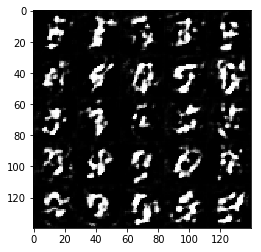

Epoch 1/2... Generator Loss: 1.1203 Discriminator Loss: 1.5184...
Epoch 1/2... Generator Loss: 0.8098 Discriminator Loss: 1.4491...
Epoch 1/2... Generator Loss: 0.5113 Discriminator Loss: 1.6273...
Epoch 1/2... Generator Loss: 0.8808 Discriminator Loss: 1.4130...
Epoch 1/2... Generator Loss: 1.2797 Discriminator Loss: 1.6180...
Epoch 1/2... Generator Loss: 0.6597 Discriminator Loss: 1.5058...
Epoch 1/2... Generator Loss: 0.9486 Discriminator Loss: 1.4446...
Epoch 1/2... Generator Loss: 0.7407 Discriminator Loss: 1.4057...
Epoch 1/2... Generator Loss: 1.0982 Discriminator Loss: 1.4541...
Epoch 1/2... Generator Loss: 1.0170 Discriminator Loss: 1.4982...


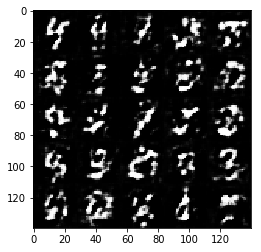

Epoch 1/2... Generator Loss: 0.5831 Discriminator Loss: 1.4711...
Epoch 1/2... Generator Loss: 1.0774 Discriminator Loss: 1.5484...
Epoch 1/2... Generator Loss: 0.8147 Discriminator Loss: 1.3799...
Epoch 1/2... Generator Loss: 0.9888 Discriminator Loss: 1.3508...
Epoch 1/2... Generator Loss: 1.1518 Discriminator Loss: 1.5180...
Epoch 1/2... Generator Loss: 1.0459 Discriminator Loss: 1.4431...
Epoch 1/2... Generator Loss: 0.6183 Discriminator Loss: 1.4427...
Epoch 1/2... Generator Loss: 0.9279 Discriminator Loss: 1.4310...
Epoch 1/2... Generator Loss: 0.6298 Discriminator Loss: 1.4817...
Epoch 1/2... Generator Loss: 0.7721 Discriminator Loss: 1.4138...


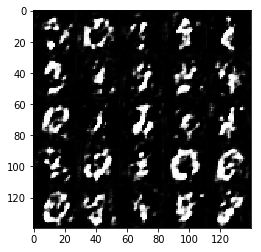

Epoch 1/2... Generator Loss: 0.4938 Discriminator Loss: 1.4653...
Epoch 1/2... Generator Loss: 0.7749 Discriminator Loss: 1.3877...
Epoch 1/2... Generator Loss: 0.4465 Discriminator Loss: 1.5086...
Epoch 1/2... Generator Loss: 1.0307 Discriminator Loss: 1.6502...
Epoch 1/2... Generator Loss: 0.9251 Discriminator Loss: 1.4177...
Epoch 1/2... Generator Loss: 0.6556 Discriminator Loss: 1.3946...
Epoch 1/2... Generator Loss: 0.6853 Discriminator Loss: 1.4306...
Epoch 1/2... Generator Loss: 0.7692 Discriminator Loss: 1.4941...
Epoch 1/2... Generator Loss: 0.7251 Discriminator Loss: 1.4266...
Epoch 1/2... Generator Loss: 0.6376 Discriminator Loss: 1.4146...


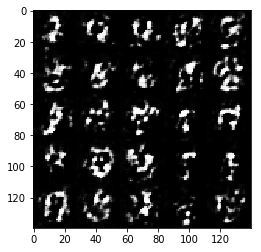

Epoch 1/2... Generator Loss: 0.6757 Discriminator Loss: 1.4307...
Epoch 1/2... Generator Loss: 0.9473 Discriminator Loss: 1.4290...
Epoch 1/2... Generator Loss: 0.8853 Discriminator Loss: 1.3743...
Epoch 1/2... Generator Loss: 0.5371 Discriminator Loss: 1.6272...
Epoch 1/2... Generator Loss: 1.1427 Discriminator Loss: 1.5201...
Epoch 1/2... Generator Loss: 0.8586 Discriminator Loss: 1.3528...
Epoch 1/2... Generator Loss: 0.9487 Discriminator Loss: 1.4336...
Epoch 1/2... Generator Loss: 0.7733 Discriminator Loss: 1.3877...
Epoch 1/2... Generator Loss: 1.0979 Discriminator Loss: 1.5648...
Epoch 1/2... Generator Loss: 0.9351 Discriminator Loss: 1.4563...


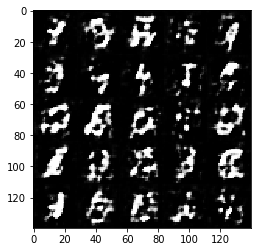

Epoch 1/2... Generator Loss: 0.4945 Discriminator Loss: 1.5023...
Epoch 1/2... Generator Loss: 0.9679 Discriminator Loss: 1.4259...
Epoch 1/2... Generator Loss: 0.5117 Discriminator Loss: 1.4138...
Epoch 1/2... Generator Loss: 0.9345 Discriminator Loss: 1.4985...
Epoch 1/2... Generator Loss: 1.1132 Discriminator Loss: 1.4931...
Epoch 1/2... Generator Loss: 1.1177 Discriminator Loss: 1.4350...
Epoch 1/2... Generator Loss: 0.7247 Discriminator Loss: 1.4220...
Epoch 1/2... Generator Loss: 0.8911 Discriminator Loss: 1.4331...
Epoch 1/2... Generator Loss: 0.7568 Discriminator Loss: 1.5295...
Epoch 1/2... Generator Loss: 0.5839 Discriminator Loss: 1.4705...


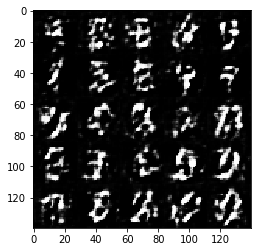

Epoch 1/2... Generator Loss: 0.8124 Discriminator Loss: 1.3963...
Epoch 1/2... Generator Loss: 0.8195 Discriminator Loss: 1.4331...
Epoch 1/2... Generator Loss: 0.5195 Discriminator Loss: 1.5114...
Epoch 1/2... Generator Loss: 0.6682 Discriminator Loss: 1.4250...
Epoch 1/2... Generator Loss: 0.6632 Discriminator Loss: 1.3770...
Epoch 1/2... Generator Loss: 0.5703 Discriminator Loss: 1.4912...
Epoch 1/2... Generator Loss: 0.8509 Discriminator Loss: 1.3875...
Epoch 1/2... Generator Loss: 0.5801 Discriminator Loss: 1.5280...
Epoch 1/2... Generator Loss: 0.6451 Discriminator Loss: 1.4520...
Epoch 1/2... Generator Loss: 0.8516 Discriminator Loss: 1.4641...


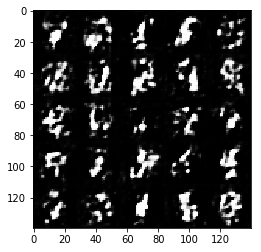

Epoch 1/2... Generator Loss: 0.9628 Discriminator Loss: 1.4238...
Epoch 1/2... Generator Loss: 1.1537 Discriminator Loss: 1.4282...
Epoch 1/2... Generator Loss: 0.7475 Discriminator Loss: 1.4728...
Epoch 1/2... Generator Loss: 0.7797 Discriminator Loss: 1.4274...
Epoch 1/2... Generator Loss: 0.9144 Discriminator Loss: 1.3982...
Epoch 1/2... Generator Loss: 1.1742 Discriminator Loss: 1.4783...
Epoch 1/2... Generator Loss: 0.8059 Discriminator Loss: 1.3731...
Epoch 1/2... Generator Loss: 0.9644 Discriminator Loss: 1.4588...
Epoch 1/2... Generator Loss: 0.8956 Discriminator Loss: 1.3503...
Epoch 1/2... Generator Loss: 0.8243 Discriminator Loss: 1.3997...


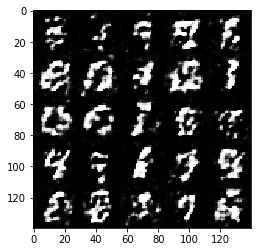

Epoch 1/2... Generator Loss: 0.9920 Discriminator Loss: 1.4023...
Epoch 1/2... Generator Loss: 1.0005 Discriminator Loss: 1.5411...
Epoch 1/2... Generator Loss: 0.6413 Discriminator Loss: 1.4316...
Epoch 1/2... Generator Loss: 0.5368 Discriminator Loss: 1.4621...
Epoch 1/2... Generator Loss: 0.7574 Discriminator Loss: 1.4120...
Epoch 1/2... Generator Loss: 1.0227 Discriminator Loss: 1.4868...
Epoch 1/2... Generator Loss: 0.5200 Discriminator Loss: 1.4949...
Epoch 2/2... Generator Loss: 0.9820 Discriminator Loss: 1.4166...
Epoch 2/2... Generator Loss: 1.0754 Discriminator Loss: 1.4253...
Epoch 2/2... Generator Loss: 0.7695 Discriminator Loss: 1.4138...


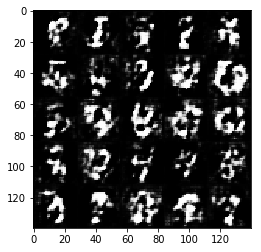

Epoch 2/2... Generator Loss: 0.7683 Discriminator Loss: 1.4882...
Epoch 2/2... Generator Loss: 0.6421 Discriminator Loss: 1.4453...
Epoch 2/2... Generator Loss: 0.5459 Discriminator Loss: 1.4759...
Epoch 2/2... Generator Loss: 0.7707 Discriminator Loss: 1.4216...
Epoch 2/2... Generator Loss: 0.9764 Discriminator Loss: 1.4244...
Epoch 2/2... Generator Loss: 0.8262 Discriminator Loss: 1.3946...
Epoch 2/2... Generator Loss: 0.8496 Discriminator Loss: 1.3892...
Epoch 2/2... Generator Loss: 0.8003 Discriminator Loss: 1.3904...
Epoch 2/2... Generator Loss: 0.4818 Discriminator Loss: 1.5227...
Epoch 2/2... Generator Loss: 0.9129 Discriminator Loss: 1.4070...


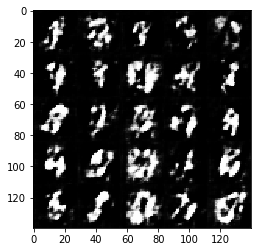

Epoch 2/2... Generator Loss: 0.9373 Discriminator Loss: 1.3790...
Epoch 2/2... Generator Loss: 0.7548 Discriminator Loss: 1.4029...
Epoch 2/2... Generator Loss: 0.7383 Discriminator Loss: 1.4254...
Epoch 2/2... Generator Loss: 0.5215 Discriminator Loss: 1.4410...
Epoch 2/2... Generator Loss: 0.6068 Discriminator Loss: 1.4656...
Epoch 2/2... Generator Loss: 0.7701 Discriminator Loss: 1.3897...
Epoch 2/2... Generator Loss: 0.8066 Discriminator Loss: 1.4234...
Epoch 2/2... Generator Loss: 1.0800 Discriminator Loss: 1.4576...
Epoch 2/2... Generator Loss: 0.7576 Discriminator Loss: 1.3949...
Epoch 2/2... Generator Loss: 1.3711 Discriminator Loss: 1.6119...


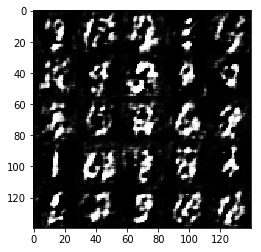

Epoch 2/2... Generator Loss: 0.7478 Discriminator Loss: 1.3654...
Epoch 2/2... Generator Loss: 0.7572 Discriminator Loss: 1.4398...
Epoch 2/2... Generator Loss: 0.7126 Discriminator Loss: 1.4248...
Epoch 2/2... Generator Loss: 0.6605 Discriminator Loss: 1.4176...
Epoch 2/2... Generator Loss: 0.5763 Discriminator Loss: 1.4361...
Epoch 2/2... Generator Loss: 0.8374 Discriminator Loss: 1.4276...
Epoch 2/2... Generator Loss: 0.8401 Discriminator Loss: 1.3832...
Epoch 2/2... Generator Loss: 1.0791 Discriminator Loss: 1.5158...
Epoch 2/2... Generator Loss: 0.9141 Discriminator Loss: 1.4186...
Epoch 2/2... Generator Loss: 0.9948 Discriminator Loss: 1.4180...


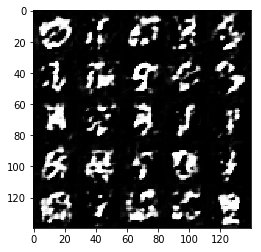

Epoch 2/2... Generator Loss: 0.8509 Discriminator Loss: 1.3270...
Epoch 2/2... Generator Loss: 0.8978 Discriminator Loss: 1.3789...
Epoch 2/2... Generator Loss: 1.1625 Discriminator Loss: 1.5785...
Epoch 2/2... Generator Loss: 1.0629 Discriminator Loss: 1.4245...
Epoch 2/2... Generator Loss: 1.0304 Discriminator Loss: 1.4403...
Epoch 2/2... Generator Loss: 1.1050 Discriminator Loss: 1.4468...
Epoch 2/2... Generator Loss: 0.7897 Discriminator Loss: 1.4660...
Epoch 2/2... Generator Loss: 1.0868 Discriminator Loss: 1.4414...
Epoch 2/2... Generator Loss: 1.0228 Discriminator Loss: 1.4160...
Epoch 2/2... Generator Loss: 1.1739 Discriminator Loss: 1.4477...


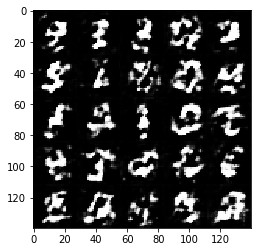

Epoch 2/2... Generator Loss: 0.8393 Discriminator Loss: 1.4327...
Epoch 2/2... Generator Loss: 0.8974 Discriminator Loss: 1.4315...
Epoch 2/2... Generator Loss: 1.2763 Discriminator Loss: 1.5285...
Epoch 2/2... Generator Loss: 0.6241 Discriminator Loss: 1.4392...
Epoch 2/2... Generator Loss: 0.5807 Discriminator Loss: 1.4999...
Epoch 2/2... Generator Loss: 0.9407 Discriminator Loss: 1.4073...
Epoch 2/2... Generator Loss: 0.9193 Discriminator Loss: 1.4421...
Epoch 2/2... Generator Loss: 0.7587 Discriminator Loss: 1.4345...
Epoch 2/2... Generator Loss: 0.7782 Discriminator Loss: 1.3899...
Epoch 2/2... Generator Loss: 0.9259 Discriminator Loss: 1.4619...


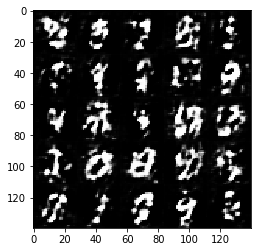

Epoch 2/2... Generator Loss: 0.9776 Discriminator Loss: 1.4205...
Epoch 2/2... Generator Loss: 0.5139 Discriminator Loss: 1.5212...
Epoch 2/2... Generator Loss: 0.8384 Discriminator Loss: 1.3989...
Epoch 2/2... Generator Loss: 0.5450 Discriminator Loss: 1.4643...
Epoch 2/2... Generator Loss: 0.6809 Discriminator Loss: 1.4020...
Epoch 2/2... Generator Loss: 0.5366 Discriminator Loss: 1.5156...
Epoch 2/2... Generator Loss: 0.7955 Discriminator Loss: 1.3682...
Epoch 2/2... Generator Loss: 0.7762 Discriminator Loss: 1.3808...
Epoch 2/2... Generator Loss: 0.9479 Discriminator Loss: 1.4746...
Epoch 2/2... Generator Loss: 0.8625 Discriminator Loss: 1.3900...


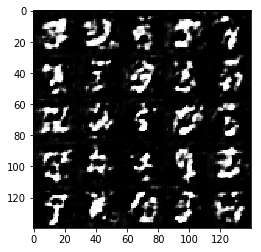

Epoch 2/2... Generator Loss: 0.6629 Discriminator Loss: 1.4132...
Epoch 2/2... Generator Loss: 0.5368 Discriminator Loss: 1.4159...
Epoch 2/2... Generator Loss: 0.6615 Discriminator Loss: 1.3810...
Epoch 2/2... Generator Loss: 0.7183 Discriminator Loss: 1.4005...
Epoch 2/2... Generator Loss: 0.6099 Discriminator Loss: 1.4460...
Epoch 2/2... Generator Loss: 0.8710 Discriminator Loss: 1.4068...
Epoch 2/2... Generator Loss: 0.7402 Discriminator Loss: 1.4100...
Epoch 2/2... Generator Loss: 0.4518 Discriminator Loss: 1.5680...
Epoch 2/2... Generator Loss: 0.6012 Discriminator Loss: 1.4259...
Epoch 2/2... Generator Loss: 0.8218 Discriminator Loss: 1.4373...


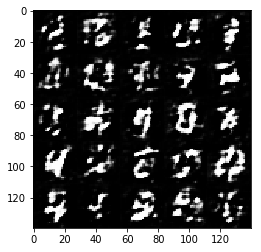

Epoch 2/2... Generator Loss: 0.9111 Discriminator Loss: 1.4199...
Epoch 2/2... Generator Loss: 1.1403 Discriminator Loss: 1.4439...
Epoch 2/2... Generator Loss: 0.8265 Discriminator Loss: 1.3664...
Epoch 2/2... Generator Loss: 0.9219 Discriminator Loss: 1.4188...
Epoch 2/2... Generator Loss: 0.7248 Discriminator Loss: 1.4021...
Epoch 2/2... Generator Loss: 1.0466 Discriminator Loss: 1.4231...
Epoch 2/2... Generator Loss: 1.2850 Discriminator Loss: 1.4618...
Epoch 2/2... Generator Loss: 0.6694 Discriminator Loss: 1.4590...
Epoch 2/2... Generator Loss: 0.9551 Discriminator Loss: 1.4381...
Epoch 2/2... Generator Loss: 0.9498 Discriminator Loss: 1.4600...


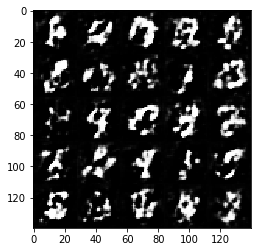

Epoch 2/2... Generator Loss: 0.7886 Discriminator Loss: 1.4479...
Epoch 2/2... Generator Loss: 0.7844 Discriminator Loss: 1.3857...
Epoch 2/2... Generator Loss: 0.5777 Discriminator Loss: 1.4664...
Epoch 2/2... Generator Loss: 0.7862 Discriminator Loss: 1.4131...
Epoch 2/2... Generator Loss: 0.7509 Discriminator Loss: 1.3745...
Epoch 2/2... Generator Loss: 0.7944 Discriminator Loss: 1.3826...
Epoch 2/2... Generator Loss: 0.7222 Discriminator Loss: 1.3628...
Epoch 2/2... Generator Loss: 0.6650 Discriminator Loss: 1.3993...
Epoch 2/2... Generator Loss: 0.7065 Discriminator Loss: 1.4014...
Epoch 2/2... Generator Loss: 0.8117 Discriminator Loss: 1.4688...


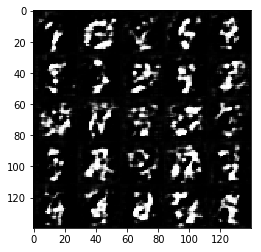

Epoch 2/2... Generator Loss: 0.7202 Discriminator Loss: 1.4772...
Epoch 2/2... Generator Loss: 1.1423 Discriminator Loss: 1.4176...
Epoch 2/2... Generator Loss: 0.9738 Discriminator Loss: 1.4062...
Epoch 2/2... Generator Loss: 0.7039 Discriminator Loss: 1.4948...
Epoch 2/2... Generator Loss: 1.0270 Discriminator Loss: 1.4946...
Epoch 2/2... Generator Loss: 0.9724 Discriminator Loss: 1.4049...
Epoch 2/2... Generator Loss: 0.7829 Discriminator Loss: 1.4357...
Epoch 2/2... Generator Loss: 0.5482 Discriminator Loss: 1.4587...
Epoch 2/2... Generator Loss: 0.6936 Discriminator Loss: 1.3691...
Epoch 2/2... Generator Loss: 0.7529 Discriminator Loss: 1.3471...


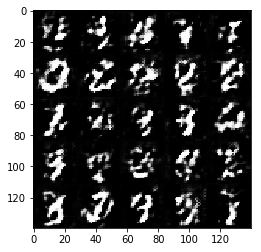

Epoch 2/2... Generator Loss: 1.0201 Discriminator Loss: 1.4402...
Epoch 2/2... Generator Loss: 1.1680 Discriminator Loss: 1.5138...
Epoch 2/2... Generator Loss: 0.8413 Discriminator Loss: 1.4691...
Epoch 2/2... Generator Loss: 0.8344 Discriminator Loss: 1.3374...
Epoch 2/2... Generator Loss: 1.0792 Discriminator Loss: 1.3764...
Epoch 2/2... Generator Loss: 0.5494 Discriminator Loss: 1.4873...
Epoch 2/2... Generator Loss: 0.5739 Discriminator Loss: 1.4154...
Epoch 2/2... Generator Loss: 0.8076 Discriminator Loss: 1.3646...
Epoch 2/2... Generator Loss: 0.8422 Discriminator Loss: 1.3621...
Epoch 2/2... Generator Loss: 1.1148 Discriminator Loss: 1.5475...


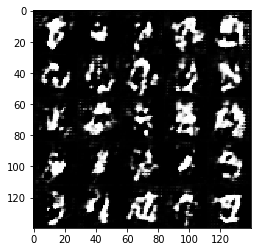

Epoch 2/2... Generator Loss: 0.7575 Discriminator Loss: 1.3709...
Epoch 2/2... Generator Loss: 0.5548 Discriminator Loss: 1.4236...
Epoch 2/2... Generator Loss: 0.8011 Discriminator Loss: 1.4173...
Epoch 2/2... Generator Loss: 0.6663 Discriminator Loss: 1.4224...
Epoch 2/2... Generator Loss: 0.5793 Discriminator Loss: 1.4749...
Epoch 2/2... Generator Loss: 0.4247 Discriminator Loss: 1.5606...
Epoch 2/2... Generator Loss: 0.5499 Discriminator Loss: 1.4735...
Epoch 2/2... Generator Loss: 0.8786 Discriminator Loss: 1.3816...
Epoch 2/2... Generator Loss: 0.6748 Discriminator Loss: 1.4191...
Epoch 2/2... Generator Loss: 0.9474 Discriminator Loss: 1.4135...


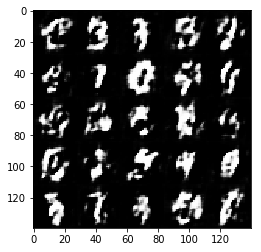

Epoch 2/2... Generator Loss: 0.9670 Discriminator Loss: 1.3837...
Epoch 2/2... Generator Loss: 0.6956 Discriminator Loss: 1.4162...
Epoch 2/2... Generator Loss: 0.8512 Discriminator Loss: 1.4303...
Epoch 2/2... Generator Loss: 1.0239 Discriminator Loss: 1.4302...
Epoch 2/2... Generator Loss: 0.7409 Discriminator Loss: 1.3634...
Epoch 2/2... Generator Loss: 0.6398 Discriminator Loss: 1.4710...
Epoch 2/2... Generator Loss: 1.0729 Discriminator Loss: 1.4541...
Epoch 2/2... Generator Loss: 0.8176 Discriminator Loss: 1.4033...
Epoch 2/2... Generator Loss: 0.7787 Discriminator Loss: 1.4180...
Epoch 2/2... Generator Loss: 1.2277 Discriminator Loss: 1.4410...


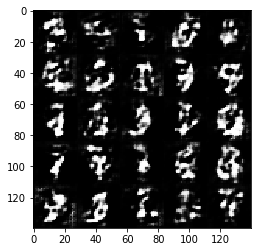

Epoch 2/2... Generator Loss: 0.6874 Discriminator Loss: 1.3782...
Epoch 2/2... Generator Loss: 0.6624 Discriminator Loss: 1.4000...
Epoch 2/2... Generator Loss: 0.5922 Discriminator Loss: 1.4791...
Epoch 2/2... Generator Loss: 0.9612 Discriminator Loss: 1.4085...
Epoch 2/2... Generator Loss: 1.2183 Discriminator Loss: 1.4841...
Epoch 2/2... Generator Loss: 0.8039 Discriminator Loss: 1.3810...
Epoch 2/2... Generator Loss: 0.6610 Discriminator Loss: 1.3821...
Epoch 2/2... Generator Loss: 0.5532 Discriminator Loss: 1.4762...
Epoch 2/2... Generator Loss: 0.7489 Discriminator Loss: 1.4055...
Epoch 2/2... Generator Loss: 0.8334 Discriminator Loss: 1.4529...


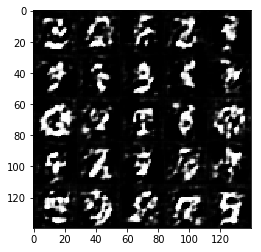

Epoch 2/2... Generator Loss: 0.6922 Discriminator Loss: 1.4629...
Epoch 2/2... Generator Loss: 0.6673 Discriminator Loss: 1.4549...
Epoch 2/2... Generator Loss: 0.6558 Discriminator Loss: 1.3929...
Epoch 2/2... Generator Loss: 0.6529 Discriminator Loss: 1.4031...
Epoch 2/2... Generator Loss: 0.6890 Discriminator Loss: 1.3969...
Epoch 2/2... Generator Loss: 0.8387 Discriminator Loss: 1.3784...
Epoch 2/2... Generator Loss: 1.1527 Discriminator Loss: 1.5457...
Epoch 2/2... Generator Loss: 0.8881 Discriminator Loss: 1.4849...
Epoch 2/2... Generator Loss: 0.6155 Discriminator Loss: 1.3943...
Epoch 2/2... Generator Loss: 0.9656 Discriminator Loss: 1.4509...


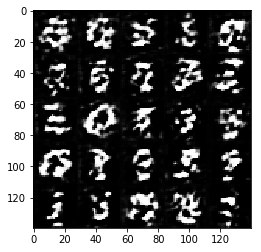

Epoch 2/2... Generator Loss: 1.0806 Discriminator Loss: 1.4481...
Epoch 2/2... Generator Loss: 0.8624 Discriminator Loss: 1.4115...
Epoch 2/2... Generator Loss: 0.7304 Discriminator Loss: 1.4224...
Epoch 2/2... Generator Loss: 0.7610 Discriminator Loss: 1.3958...
Epoch 2/2... Generator Loss: 0.9752 Discriminator Loss: 1.4542...
Epoch 2/2... Generator Loss: 0.9222 Discriminator Loss: 1.4182...
Epoch 2/2... Generator Loss: 0.8323 Discriminator Loss: 1.4405...
Epoch 2/2... Generator Loss: 0.8240 Discriminator Loss: 1.3960...
Epoch 2/2... Generator Loss: 0.7830 Discriminator Loss: 1.4086...
Epoch 2/2... Generator Loss: 0.9593 Discriminator Loss: 1.3561...


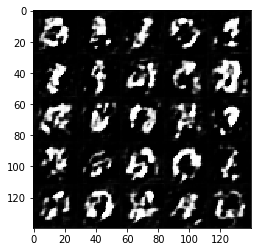

Epoch 2/2... Generator Loss: 0.8897 Discriminator Loss: 1.3760...
Epoch 2/2... Generator Loss: 0.8587 Discriminator Loss: 1.3784...
Epoch 2/2... Generator Loss: 0.6521 Discriminator Loss: 1.4073...
Epoch 2/2... Generator Loss: 0.5377 Discriminator Loss: 1.4817...
Epoch 2/2... Generator Loss: 0.6075 Discriminator Loss: 1.4875...
Epoch 2/2... Generator Loss: 1.0689 Discriminator Loss: 1.4182...
Epoch 2/2... Generator Loss: 0.9690 Discriminator Loss: 1.4689...
Epoch 2/2... Generator Loss: 0.8610 Discriminator Loss: 1.2932...
Epoch 2/2... Generator Loss: 0.6245 Discriminator Loss: 1.4198...
Epoch 2/2... Generator Loss: 0.6370 Discriminator Loss: 1.3558...


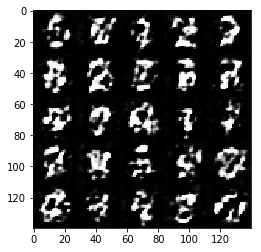

Epoch 2/2... Generator Loss: 0.7578 Discriminator Loss: 1.3804...
Epoch 2/2... Generator Loss: 0.8935 Discriminator Loss: 1.4341...
Epoch 2/2... Generator Loss: 0.6569 Discriminator Loss: 1.3781...
Epoch 2/2... Generator Loss: 0.5781 Discriminator Loss: 1.4302...
Epoch 2/2... Generator Loss: 1.0344 Discriminator Loss: 1.4341...
Epoch 2/2... Generator Loss: 0.8794 Discriminator Loss: 1.3735...
Epoch 2/2... Generator Loss: 0.8097 Discriminator Loss: 1.3532...
Epoch 2/2... Generator Loss: 0.8733 Discriminator Loss: 1.3650...
Epoch 2/2... Generator Loss: 0.9143 Discriminator Loss: 1.3574...
Epoch 2/2... Generator Loss: 0.7232 Discriminator Loss: 1.4538...


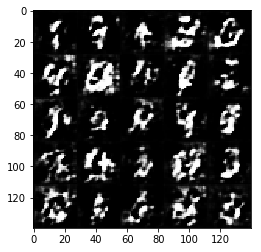

Epoch 2/2... Generator Loss: 0.7470 Discriminator Loss: 1.4314...
Epoch 2/2... Generator Loss: 0.8423 Discriminator Loss: 1.3675...
Epoch 2/2... Generator Loss: 0.8009 Discriminator Loss: 1.3947...
Epoch 2/2... Generator Loss: 1.1380 Discriminator Loss: 1.5228...
Epoch 2/2... Generator Loss: 1.0142 Discriminator Loss: 1.4434...


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial output:


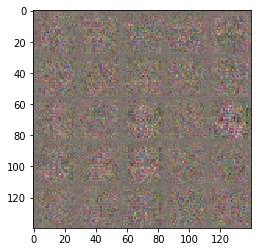

Epoch 1/1... Generator Loss: 0.5528 Discriminator Loss: 1.9463...
Epoch 1/1... Generator Loss: 0.9020 Discriminator Loss: 1.7304...
Epoch 1/1... Generator Loss: 0.4705 Discriminator Loss: 2.1310...
Epoch 1/1... Generator Loss: 1.0979 Discriminator Loss: 2.0113...
Epoch 1/1... Generator Loss: 0.7383 Discriminator Loss: 2.5787...
Epoch 1/1... Generator Loss: 2.3881 Discriminator Loss: 3.2617...
Epoch 1/1... Generator Loss: 0.7616 Discriminator Loss: 2.2444...
Epoch 1/1... Generator Loss: 1.2476 Discriminator Loss: 1.8869...
Epoch 1/1... Generator Loss: 2.1115 Discriminator Loss: 2.1098...
Epoch 1/1... Generator Loss: 0.6549 Discriminator Loss: 1.7842...


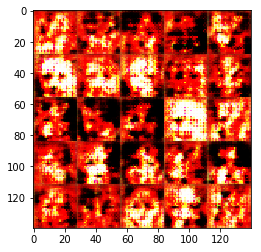

Epoch 1/1... Generator Loss: 0.6913 Discriminator Loss: 1.9120...
Epoch 1/1... Generator Loss: 1.1931 Discriminator Loss: 0.8148...
Epoch 1/1... Generator Loss: 1.3344 Discriminator Loss: 1.1135...
Epoch 1/1... Generator Loss: 1.9679 Discriminator Loss: 0.9095...
Epoch 1/1... Generator Loss: 0.4740 Discriminator Loss: 1.9737...
Epoch 1/1... Generator Loss: 1.6411 Discriminator Loss: 1.3968...
Epoch 1/1... Generator Loss: 1.5273 Discriminator Loss: 0.8974...
Epoch 1/1... Generator Loss: 1.4756 Discriminator Loss: 0.9481...
Epoch 1/1... Generator Loss: 0.8456 Discriminator Loss: 1.4263...
Epoch 1/1... Generator Loss: 2.6274 Discriminator Loss: 0.7736...


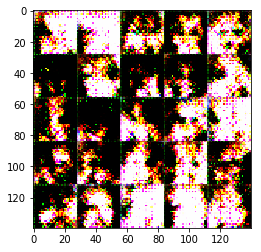

Epoch 1/1... Generator Loss: 1.2191 Discriminator Loss: 1.5264...
Epoch 1/1... Generator Loss: 1.3836 Discriminator Loss: 1.1789...
Epoch 1/1... Generator Loss: 1.9336 Discriminator Loss: 0.8964...
Epoch 1/1... Generator Loss: 1.7414 Discriminator Loss: 0.5713...
Epoch 1/1... Generator Loss: 1.7152 Discriminator Loss: 0.6441...
Epoch 1/1... Generator Loss: 2.8803 Discriminator Loss: 0.5802...
Epoch 1/1... Generator Loss: 2.1867 Discriminator Loss: 0.5050...
Epoch 1/1... Generator Loss: 6.2140 Discriminator Loss: 0.4611...
Epoch 1/1... Generator Loss: 3.7906 Discriminator Loss: 0.5154...
Epoch 1/1... Generator Loss: 4.2464 Discriminator Loss: 0.7359...


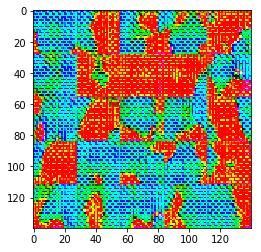

Epoch 1/1... Generator Loss: 2.1244 Discriminator Loss: 0.5711...
Epoch 1/1... Generator Loss: 3.5097 Discriminator Loss: 0.3894...
Epoch 1/1... Generator Loss: 4.9627 Discriminator Loss: 0.4263...
Epoch 1/1... Generator Loss: 3.9451 Discriminator Loss: 0.3923...
Epoch 1/1... Generator Loss: 4.3113 Discriminator Loss: 0.3791...
Epoch 1/1... Generator Loss: 3.3093 Discriminator Loss: 1.0769...
Epoch 1/1... Generator Loss: 4.9510 Discriminator Loss: 3.6826...
Epoch 1/1... Generator Loss: 1.4143 Discriminator Loss: 0.9345...
Epoch 1/1... Generator Loss: 4.3997 Discriminator Loss: 0.3907...
Epoch 1/1... Generator Loss: 2.6354 Discriminator Loss: 0.5204...


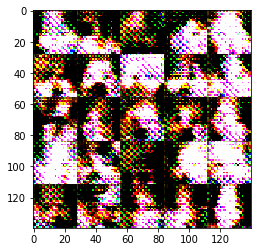

Epoch 1/1... Generator Loss: 1.6685 Discriminator Loss: 0.8127...
Epoch 1/1... Generator Loss: 2.2871 Discriminator Loss: 0.8228...
Epoch 1/1... Generator Loss: 2.3184 Discriminator Loss: 0.5023...
Epoch 1/1... Generator Loss: 3.8150 Discriminator Loss: 0.6215...
Epoch 1/1... Generator Loss: 1.2330 Discriminator Loss: 1.2146...
Epoch 1/1... Generator Loss: 1.9330 Discriminator Loss: 0.5941...
Epoch 1/1... Generator Loss: 3.2606 Discriminator Loss: 0.4279...
Epoch 1/1... Generator Loss: 2.9486 Discriminator Loss: 0.4557...
Epoch 1/1... Generator Loss: 3.5269 Discriminator Loss: 0.4279...
Epoch 1/1... Generator Loss: 5.0527 Discriminator Loss: 0.3605...


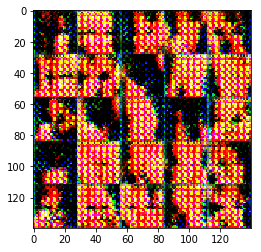

Epoch 1/1... Generator Loss: 5.8482 Discriminator Loss: 0.3473...
Epoch 1/1... Generator Loss: 2.9809 Discriminator Loss: 0.4065...
Epoch 1/1... Generator Loss: 2.7697 Discriminator Loss: 0.4608...
Epoch 1/1... Generator Loss: 5.4287 Discriminator Loss: 1.0088...
Epoch 1/1... Generator Loss: 5.8088 Discriminator Loss: 1.7071...
Epoch 1/1... Generator Loss: 3.2370 Discriminator Loss: 0.4565...
Epoch 1/1... Generator Loss: 2.9949 Discriminator Loss: 0.4160...
Epoch 1/1... Generator Loss: 4.9587 Discriminator Loss: 0.3879...
Epoch 1/1... Generator Loss: 2.0387 Discriminator Loss: 0.5866...
Epoch 1/1... Generator Loss: 3.0670 Discriminator Loss: 0.5065...


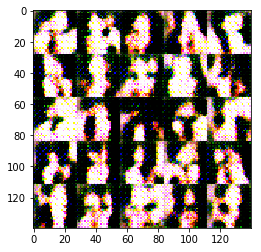

Epoch 1/1... Generator Loss: 5.6841 Discriminator Loss: 2.2621...
Epoch 1/1... Generator Loss: 4.0692 Discriminator Loss: 0.4659...
Epoch 1/1... Generator Loss: 2.9405 Discriminator Loss: 1.6912...
Epoch 1/1... Generator Loss: 4.5884 Discriminator Loss: 0.4136...
Epoch 1/1... Generator Loss: 5.4588 Discriminator Loss: 0.4699...
Epoch 1/1... Generator Loss: 4.4112 Discriminator Loss: 0.8888...
Epoch 1/1... Generator Loss: 4.9902 Discriminator Loss: 2.4433...
Epoch 1/1... Generator Loss: 3.5114 Discriminator Loss: 0.5896...
Epoch 1/1... Generator Loss: 2.3250 Discriminator Loss: 0.4934...
Epoch 1/1... Generator Loss: 2.6209 Discriminator Loss: 1.1162...


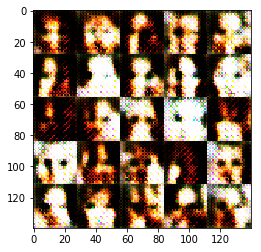

Epoch 1/1... Generator Loss: 3.5947 Discriminator Loss: 0.5806...
Epoch 1/1... Generator Loss: 0.8823 Discriminator Loss: 1.2168...
Epoch 1/1... Generator Loss: 2.5847 Discriminator Loss: 0.7078...
Epoch 1/1... Generator Loss: 4.3627 Discriminator Loss: 0.9138...
Epoch 1/1... Generator Loss: 0.7385 Discriminator Loss: 1.4497...
Epoch 1/1... Generator Loss: 5.7851 Discriminator Loss: 0.3834...
Epoch 1/1... Generator Loss: 4.6461 Discriminator Loss: 0.3886...
Epoch 1/1... Generator Loss: 2.7544 Discriminator Loss: 0.4517...
Epoch 1/1... Generator Loss: 2.7528 Discriminator Loss: 0.9512...
Epoch 1/1... Generator Loss: 2.9931 Discriminator Loss: 0.7081...


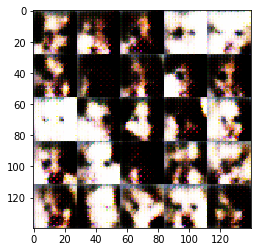

Epoch 1/1... Generator Loss: 4.2239 Discriminator Loss: 1.1839...
Epoch 1/1... Generator Loss: 3.7960 Discriminator Loss: 0.3806...
Epoch 1/1... Generator Loss: 3.0974 Discriminator Loss: 0.4319...
Epoch 1/1... Generator Loss: 1.7881 Discriminator Loss: 0.6275...
Epoch 1/1... Generator Loss: 6.0850 Discriminator Loss: 2.7635...
Epoch 1/1... Generator Loss: 1.4525 Discriminator Loss: 0.8196...
Epoch 1/1... Generator Loss: 1.5606 Discriminator Loss: 0.9756...
Epoch 1/1... Generator Loss: 1.3309 Discriminator Loss: 0.9667...
Epoch 1/1... Generator Loss: 0.9103 Discriminator Loss: 2.5141...
Epoch 1/1... Generator Loss: 1.3552 Discriminator Loss: 3.0549...


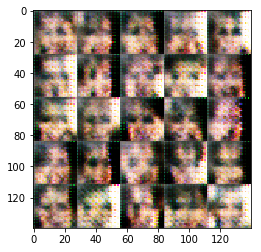

Epoch 1/1... Generator Loss: 0.7618 Discriminator Loss: 1.2728...
Epoch 1/1... Generator Loss: 5.2127 Discriminator Loss: 0.5278...
Epoch 1/1... Generator Loss: 1.7450 Discriminator Loss: 1.3958...
Epoch 1/1... Generator Loss: 1.3134 Discriminator Loss: 1.5851...
Epoch 1/1... Generator Loss: 1.1822 Discriminator Loss: 2.4276...
Epoch 1/1... Generator Loss: 0.2743 Discriminator Loss: 2.2310...
Epoch 1/1... Generator Loss: 0.7512 Discriminator Loss: 1.2504...
Epoch 1/1... Generator Loss: 2.2403 Discriminator Loss: 0.5656...
Epoch 1/1... Generator Loss: 0.5926 Discriminator Loss: 1.3859...
Epoch 1/1... Generator Loss: 1.0804 Discriminator Loss: 1.8773...


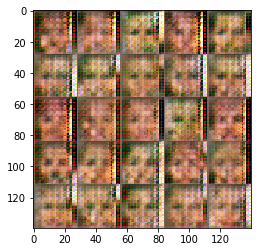

Epoch 1/1... Generator Loss: 1.0393 Discriminator Loss: 0.8890...
Epoch 1/1... Generator Loss: 1.2018 Discriminator Loss: 1.2362...
Epoch 1/1... Generator Loss: 1.0527 Discriminator Loss: 1.0816...
Epoch 1/1... Generator Loss: 0.7743 Discriminator Loss: 1.3629...
Epoch 1/1... Generator Loss: 3.0055 Discriminator Loss: 1.7044...
Epoch 1/1... Generator Loss: 1.4136 Discriminator Loss: 1.9337...
Epoch 1/1... Generator Loss: 2.0925 Discriminator Loss: 2.0983...
Epoch 1/1... Generator Loss: 2.3201 Discriminator Loss: 0.9986...
Epoch 1/1... Generator Loss: 1.5214 Discriminator Loss: 1.1030...
Epoch 1/1... Generator Loss: 0.4046 Discriminator Loss: 2.0661...


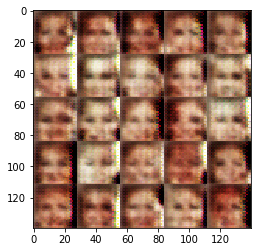

Epoch 1/1... Generator Loss: 0.6372 Discriminator Loss: 1.4692...
Epoch 1/1... Generator Loss: 1.5812 Discriminator Loss: 1.0112...
Epoch 1/1... Generator Loss: 3.1821 Discriminator Loss: 2.1652...
Epoch 1/1... Generator Loss: 0.3737 Discriminator Loss: 1.7515...
Epoch 1/1... Generator Loss: 0.8677 Discriminator Loss: 1.3989...
Epoch 1/1... Generator Loss: 1.6172 Discriminator Loss: 1.3343...
Epoch 1/1... Generator Loss: 3.1186 Discriminator Loss: 0.6884...
Epoch 1/1... Generator Loss: 0.6850 Discriminator Loss: 1.5329...
Epoch 1/1... Generator Loss: 1.3079 Discriminator Loss: 1.4680...
Epoch 1/1... Generator Loss: 0.6761 Discriminator Loss: 1.5490...


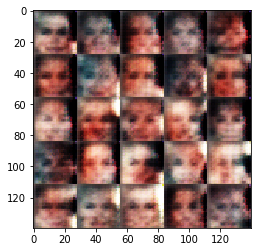

Epoch 1/1... Generator Loss: 0.1307 Discriminator Loss: 2.7698...
Epoch 1/1... Generator Loss: 1.1524 Discriminator Loss: 1.0516...
Epoch 1/1... Generator Loss: 3.3674 Discriminator Loss: 3.0101...
Epoch 1/1... Generator Loss: 0.5408 Discriminator Loss: 1.3954...
Epoch 1/1... Generator Loss: 0.8751 Discriminator Loss: 1.2294...
Epoch 1/1... Generator Loss: 2.9372 Discriminator Loss: 0.8673...
Epoch 1/1... Generator Loss: 1.0219 Discriminator Loss: 1.6737...
Epoch 1/1... Generator Loss: 1.6497 Discriminator Loss: 1.0552...
Epoch 1/1... Generator Loss: 0.8558 Discriminator Loss: 1.4058...
Epoch 1/1... Generator Loss: 0.3362 Discriminator Loss: 1.7883...


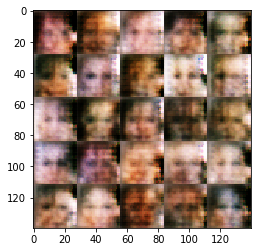

Epoch 1/1... Generator Loss: 0.9089 Discriminator Loss: 1.6055...
Epoch 1/1... Generator Loss: 0.3329 Discriminator Loss: 1.8534...
Epoch 1/1... Generator Loss: 0.5998 Discriminator Loss: 1.5199...
Epoch 1/1... Generator Loss: 0.8857 Discriminator Loss: 1.4153...
Epoch 1/1... Generator Loss: 1.8889 Discriminator Loss: 1.4419...
Epoch 1/1... Generator Loss: 1.5061 Discriminator Loss: 1.2549...
Epoch 1/1... Generator Loss: 0.6508 Discriminator Loss: 1.3858...
Epoch 1/1... Generator Loss: 0.6848 Discriminator Loss: 1.5184...
Epoch 1/1... Generator Loss: 0.8556 Discriminator Loss: 1.3418...
Epoch 1/1... Generator Loss: 0.5541 Discriminator Loss: 1.5960...


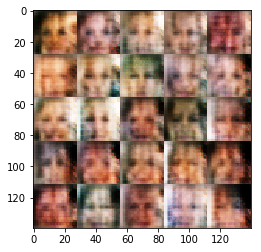

Epoch 1/1... Generator Loss: 1.2353 Discriminator Loss: 1.5953...
Epoch 1/1... Generator Loss: 0.8456 Discriminator Loss: 1.5190...
Epoch 1/1... Generator Loss: 1.2569 Discriminator Loss: 1.4831...
Epoch 1/1... Generator Loss: 0.9890 Discriminator Loss: 1.5667...
Epoch 1/1... Generator Loss: 1.1030 Discriminator Loss: 1.4415...
Epoch 1/1... Generator Loss: 1.2458 Discriminator Loss: 1.3050...
Epoch 1/1... Generator Loss: 0.9136 Discriminator Loss: 1.4370...
Epoch 1/1... Generator Loss: 0.6302 Discriminator Loss: 1.4435...
Epoch 1/1... Generator Loss: 1.4130 Discriminator Loss: 1.1522...
Epoch 1/1... Generator Loss: 1.1780 Discriminator Loss: 1.3611...


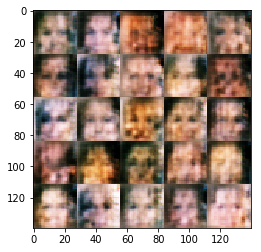

Epoch 1/1... Generator Loss: 0.6523 Discriminator Loss: 1.3294...
Epoch 1/1... Generator Loss: 1.3620 Discriminator Loss: 1.4310...
Epoch 1/1... Generator Loss: 0.6481 Discriminator Loss: 1.4892...
Epoch 1/1... Generator Loss: 0.8964 Discriminator Loss: 1.4978...
Epoch 1/1... Generator Loss: 0.5525 Discriminator Loss: 1.9738...
Epoch 1/1... Generator Loss: 1.1952 Discriminator Loss: 1.1675...
Epoch 1/1... Generator Loss: 1.7153 Discriminator Loss: 1.8047...
Epoch 1/1... Generator Loss: 1.1735 Discriminator Loss: 1.5656...
Epoch 1/1... Generator Loss: 1.0174 Discriminator Loss: 1.3484...
Epoch 1/1... Generator Loss: 0.7705 Discriminator Loss: 1.6097...


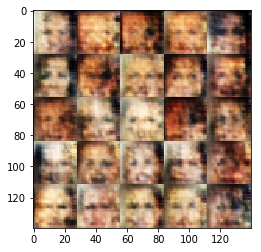

Epoch 1/1... Generator Loss: 0.8322 Discriminator Loss: 1.4679...
Epoch 1/1... Generator Loss: 0.9101 Discriminator Loss: 1.4046...
Epoch 1/1... Generator Loss: 0.9766 Discriminator Loss: 1.3442...
Epoch 1/1... Generator Loss: 0.8511 Discriminator Loss: 1.3641...
Epoch 1/1... Generator Loss: 0.7106 Discriminator Loss: 1.4766...
Epoch 1/1... Generator Loss: 0.6638 Discriminator Loss: 1.4514...
Epoch 1/1... Generator Loss: 0.8140 Discriminator Loss: 1.4430...
Epoch 1/1... Generator Loss: 0.8545 Discriminator Loss: 1.4587...
Epoch 1/1... Generator Loss: 0.9097 Discriminator Loss: 1.4213...
Epoch 1/1... Generator Loss: 0.8436 Discriminator Loss: 1.3620...


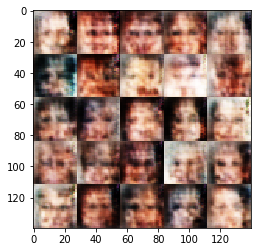

Epoch 1/1... Generator Loss: 1.0491 Discriminator Loss: 1.4649...
Epoch 1/1... Generator Loss: 0.9606 Discriminator Loss: 1.2751...
Epoch 1/1... Generator Loss: 0.4767 Discriminator Loss: 1.5318...
Epoch 1/1... Generator Loss: 0.7241 Discriminator Loss: 1.5000...
Epoch 1/1... Generator Loss: 0.6298 Discriminator Loss: 1.4915...
Epoch 1/1... Generator Loss: 0.7296 Discriminator Loss: 1.5662...
Epoch 1/1... Generator Loss: 1.0684 Discriminator Loss: 1.3378...
Epoch 1/1... Generator Loss: 1.0403 Discriminator Loss: 1.4036...
Epoch 1/1... Generator Loss: 0.8333 Discriminator Loss: 1.4576...
Epoch 1/1... Generator Loss: 1.0522 Discriminator Loss: 1.4020...


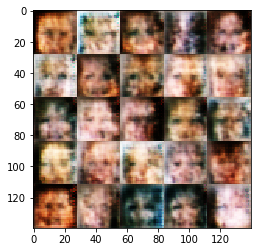

Epoch 1/1... Generator Loss: 0.9425 Discriminator Loss: 1.3065...
Epoch 1/1... Generator Loss: 0.6918 Discriminator Loss: 1.4958...
Epoch 1/1... Generator Loss: 0.8651 Discriminator Loss: 1.4410...
Epoch 1/1... Generator Loss: 0.8176 Discriminator Loss: 1.3150...
Epoch 1/1... Generator Loss: 0.6352 Discriminator Loss: 1.4274...
Epoch 1/1... Generator Loss: 0.9480 Discriminator Loss: 1.4725...
Epoch 1/1... Generator Loss: 0.9212 Discriminator Loss: 1.4704...
Epoch 1/1... Generator Loss: 0.9450 Discriminator Loss: 1.4143...
Epoch 1/1... Generator Loss: 0.7149 Discriminator Loss: 1.3647...
Epoch 1/1... Generator Loss: 0.9582 Discriminator Loss: 1.4020...


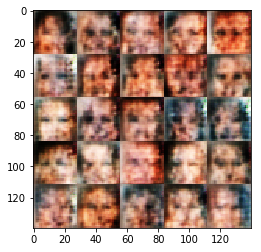

Epoch 1/1... Generator Loss: 0.9252 Discriminator Loss: 1.5180...
Epoch 1/1... Generator Loss: 0.8518 Discriminator Loss: 1.4421...
Epoch 1/1... Generator Loss: 0.7779 Discriminator Loss: 1.3991...
Epoch 1/1... Generator Loss: 0.8343 Discriminator Loss: 1.1924...
Epoch 1/1... Generator Loss: 0.7449 Discriminator Loss: 1.5675...
Epoch 1/1... Generator Loss: 0.8558 Discriminator Loss: 1.5047...
Epoch 1/1... Generator Loss: 1.0110 Discriminator Loss: 1.4763...
Epoch 1/1... Generator Loss: 0.8271 Discriminator Loss: 1.3027...
Epoch 1/1... Generator Loss: 0.7501 Discriminator Loss: 1.4277...
Epoch 1/1... Generator Loss: 0.9302 Discriminator Loss: 1.6923...


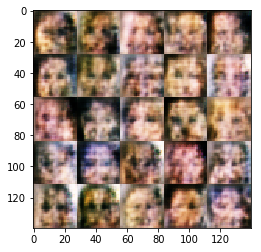

Epoch 1/1... Generator Loss: 0.7102 Discriminator Loss: 1.4771...
Epoch 1/1... Generator Loss: 0.8356 Discriminator Loss: 1.4070...
Epoch 1/1... Generator Loss: 0.9317 Discriminator Loss: 1.2954...
Epoch 1/1... Generator Loss: 0.8164 Discriminator Loss: 1.3697...
Epoch 1/1... Generator Loss: 0.6223 Discriminator Loss: 1.4863...
Epoch 1/1... Generator Loss: 0.8919 Discriminator Loss: 1.3406...
Epoch 1/1... Generator Loss: 0.7432 Discriminator Loss: 1.4372...
Epoch 1/1... Generator Loss: 0.6773 Discriminator Loss: 1.4590...
Epoch 1/1... Generator Loss: 0.9120 Discriminator Loss: 1.4319...
Epoch 1/1... Generator Loss: 0.7613 Discriminator Loss: 1.4521...


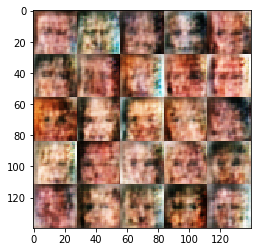

Epoch 1/1... Generator Loss: 1.2563 Discriminator Loss: 1.4816...
Epoch 1/1... Generator Loss: 0.8940 Discriminator Loss: 1.2814...
Epoch 1/1... Generator Loss: 0.8708 Discriminator Loss: 1.3474...
Epoch 1/1... Generator Loss: 0.7558 Discriminator Loss: 1.3782...
Epoch 1/1... Generator Loss: 0.8049 Discriminator Loss: 1.3658...
Epoch 1/1... Generator Loss: 0.9634 Discriminator Loss: 1.4369...
Epoch 1/1... Generator Loss: 1.0227 Discriminator Loss: 1.2787...
Epoch 1/1... Generator Loss: 0.8170 Discriminator Loss: 1.3648...
Epoch 1/1... Generator Loss: 0.9897 Discriminator Loss: 1.3889...
Epoch 1/1... Generator Loss: 0.6311 Discriminator Loss: 1.5241...


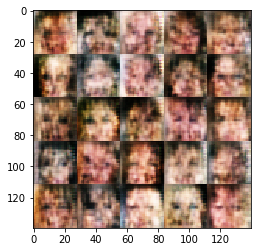

Epoch 1/1... Generator Loss: 0.7207 Discriminator Loss: 1.3597...
Epoch 1/1... Generator Loss: 0.8073 Discriminator Loss: 1.3729...
Epoch 1/1... Generator Loss: 0.7561 Discriminator Loss: 1.4760...
Epoch 1/1... Generator Loss: 0.8522 Discriminator Loss: 1.4006...
Epoch 1/1... Generator Loss: 0.8509 Discriminator Loss: 1.3830...
Epoch 1/1... Generator Loss: 1.0428 Discriminator Loss: 1.3595...
Epoch 1/1... Generator Loss: 0.6636 Discriminator Loss: 1.3566...
Epoch 1/1... Generator Loss: 0.8639 Discriminator Loss: 1.4317...
Epoch 1/1... Generator Loss: 0.8133 Discriminator Loss: 1.4519...
Epoch 1/1... Generator Loss: 0.7411 Discriminator Loss: 1.4752...


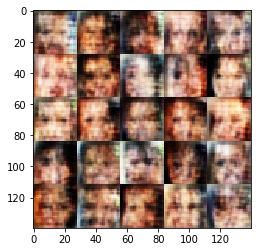

Epoch 1/1... Generator Loss: 0.8254 Discriminator Loss: 1.4063...
Epoch 1/1... Generator Loss: 0.8231 Discriminator Loss: 1.3327...
Epoch 1/1... Generator Loss: 1.1359 Discriminator Loss: 1.5217...
Epoch 1/1... Generator Loss: 0.5926 Discriminator Loss: 1.4323...
Epoch 1/1... Generator Loss: 0.7305 Discriminator Loss: 1.3864...
Epoch 1/1... Generator Loss: 0.9060 Discriminator Loss: 1.3748...
Epoch 1/1... Generator Loss: 0.7673 Discriminator Loss: 1.3453...
Epoch 1/1... Generator Loss: 0.7473 Discriminator Loss: 1.5163...
Epoch 1/1... Generator Loss: 0.7763 Discriminator Loss: 1.5811...
Epoch 1/1... Generator Loss: 0.6484 Discriminator Loss: 1.4395...


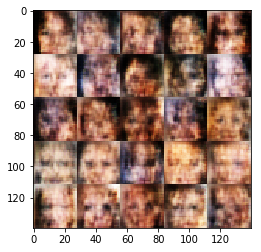

Epoch 1/1... Generator Loss: 0.9372 Discriminator Loss: 1.3833...
Epoch 1/1... Generator Loss: 0.9199 Discriminator Loss: 1.3656...
Epoch 1/1... Generator Loss: 0.8522 Discriminator Loss: 1.3471...
Epoch 1/1... Generator Loss: 0.5810 Discriminator Loss: 1.4859...
Epoch 1/1... Generator Loss: 0.9350 Discriminator Loss: 1.3494...
Epoch 1/1... Generator Loss: 0.8526 Discriminator Loss: 1.3726...
Epoch 1/1... Generator Loss: 0.9391 Discriminator Loss: 1.4053...
Epoch 1/1... Generator Loss: 0.7616 Discriminator Loss: 1.4336...
Epoch 1/1... Generator Loss: 0.8469 Discriminator Loss: 1.4517...
Epoch 1/1... Generator Loss: 0.9222 Discriminator Loss: 1.2637...


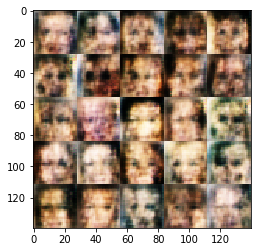

Epoch 1/1... Generator Loss: 0.9381 Discriminator Loss: 1.4450...
Epoch 1/1... Generator Loss: 0.9581 Discriminator Loss: 1.2992...
Epoch 1/1... Generator Loss: 0.9161 Discriminator Loss: 1.4079...
Epoch 1/1... Generator Loss: 0.7442 Discriminator Loss: 1.3779...
Epoch 1/1... Generator Loss: 0.8878 Discriminator Loss: 1.4105...
Epoch 1/1... Generator Loss: 0.7857 Discriminator Loss: 1.3808...
Epoch 1/1... Generator Loss: 0.6298 Discriminator Loss: 1.4493...
Epoch 1/1... Generator Loss: 0.8407 Discriminator Loss: 1.3908...
Epoch 1/1... Generator Loss: 0.7515 Discriminator Loss: 1.4039...
Epoch 1/1... Generator Loss: 0.7714 Discriminator Loss: 1.4065...


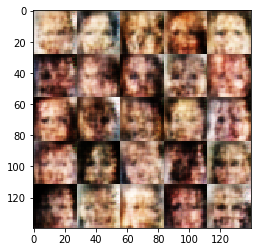

Epoch 1/1... Generator Loss: 0.7946 Discriminator Loss: 1.3789...
Epoch 1/1... Generator Loss: 0.8574 Discriminator Loss: 1.4343...
Epoch 1/1... Generator Loss: 0.8110 Discriminator Loss: 1.3202...
Epoch 1/1... Generator Loss: 0.8076 Discriminator Loss: 1.3899...
Epoch 1/1... Generator Loss: 0.8173 Discriminator Loss: 1.4414...
Epoch 1/1... Generator Loss: 1.0006 Discriminator Loss: 1.4274...
Epoch 1/1... Generator Loss: 0.7971 Discriminator Loss: 1.4202...
Epoch 1/1... Generator Loss: 0.8267 Discriminator Loss: 1.4124...
Epoch 1/1... Generator Loss: 0.8022 Discriminator Loss: 1.3197...
Epoch 1/1... Generator Loss: 0.9258 Discriminator Loss: 1.3463...


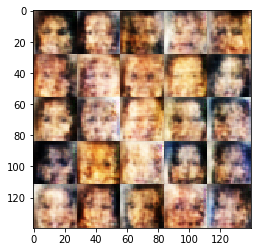

Epoch 1/1... Generator Loss: 0.6682 Discriminator Loss: 1.3679...
Epoch 1/1... Generator Loss: 0.8644 Discriminator Loss: 1.4050...
Epoch 1/1... Generator Loss: 0.9573 Discriminator Loss: 1.4221...
Epoch 1/1... Generator Loss: 0.7263 Discriminator Loss: 1.3525...
Epoch 1/1... Generator Loss: 0.8582 Discriminator Loss: 1.3600...
Epoch 1/1... Generator Loss: 0.8048 Discriminator Loss: 1.3264...
Epoch 1/1... Generator Loss: 0.8162 Discriminator Loss: 1.3254...
Epoch 1/1... Generator Loss: 0.7386 Discriminator Loss: 1.4676...
Epoch 1/1... Generator Loss: 0.8209 Discriminator Loss: 1.3346...
Epoch 1/1... Generator Loss: 0.6806 Discriminator Loss: 1.4180...


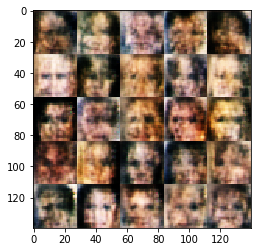

Epoch 1/1... Generator Loss: 0.7317 Discriminator Loss: 1.3880...
Epoch 1/1... Generator Loss: 0.7996 Discriminator Loss: 1.3176...
Epoch 1/1... Generator Loss: 0.7261 Discriminator Loss: 1.3828...
Epoch 1/1... Generator Loss: 0.7686 Discriminator Loss: 1.4302...
Epoch 1/1... Generator Loss: 0.7778 Discriminator Loss: 1.3932...
Epoch 1/1... Generator Loss: 0.7012 Discriminator Loss: 1.4034...
Epoch 1/1... Generator Loss: 0.8669 Discriminator Loss: 1.4468...
Epoch 1/1... Generator Loss: 1.1484 Discriminator Loss: 1.3682...
Epoch 1/1... Generator Loss: 0.8363 Discriminator Loss: 1.3539...
Epoch 1/1... Generator Loss: 0.7052 Discriminator Loss: 1.3747...


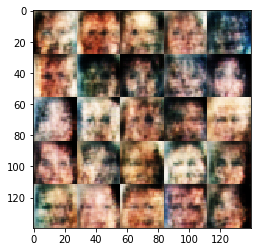

Epoch 1/1... Generator Loss: 0.7851 Discriminator Loss: 1.3216...
Epoch 1/1... Generator Loss: 0.8675 Discriminator Loss: 1.4031...
Epoch 1/1... Generator Loss: 0.8675 Discriminator Loss: 1.3751...
Epoch 1/1... Generator Loss: 0.9037 Discriminator Loss: 1.5540...
Epoch 1/1... Generator Loss: 0.9414 Discriminator Loss: 1.4146...
Epoch 1/1... Generator Loss: 0.6905 Discriminator Loss: 1.3451...
Epoch 1/1... Generator Loss: 1.4486 Discriminator Loss: 1.5132...
Epoch 1/1... Generator Loss: 0.9953 Discriminator Loss: 1.4053...
Epoch 1/1... Generator Loss: 0.8115 Discriminator Loss: 1.4622...
Epoch 1/1... Generator Loss: 0.9260 Discriminator Loss: 1.6189...


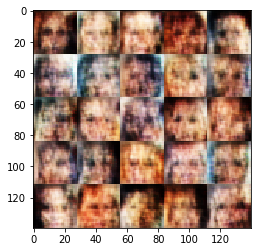

Epoch 1/1... Generator Loss: 0.7812 Discriminator Loss: 1.4130...
Epoch 1/1... Generator Loss: 0.7836 Discriminator Loss: 1.4633...
Epoch 1/1... Generator Loss: 0.8065 Discriminator Loss: 1.4143...
Epoch 1/1... Generator Loss: 0.9080 Discriminator Loss: 1.3656...
Epoch 1/1... Generator Loss: 0.9517 Discriminator Loss: 1.4967...
Epoch 1/1... Generator Loss: 0.7014 Discriminator Loss: 1.3699...
Epoch 1/1... Generator Loss: 0.9148 Discriminator Loss: 1.3617...
Epoch 1/1... Generator Loss: 0.8411 Discriminator Loss: 1.3622...
Epoch 1/1... Generator Loss: 0.8510 Discriminator Loss: 1.3952...
Epoch 1/1... Generator Loss: 0.6957 Discriminator Loss: 1.4464...


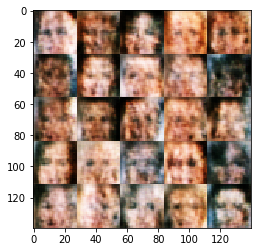

Epoch 1/1... Generator Loss: 0.9490 Discriminator Loss: 1.3392...
Epoch 1/1... Generator Loss: 0.6397 Discriminator Loss: 1.4238...
Epoch 1/1... Generator Loss: 0.7858 Discriminator Loss: 1.3201...
Epoch 1/1... Generator Loss: 0.7997 Discriminator Loss: 1.3786...
Epoch 1/1... Generator Loss: 0.8268 Discriminator Loss: 1.3975...
Epoch 1/1... Generator Loss: 0.7774 Discriminator Loss: 1.4010...
Epoch 1/1... Generator Loss: 0.8846 Discriminator Loss: 1.4135...
Epoch 1/1... Generator Loss: 0.9574 Discriminator Loss: 1.3691...
Epoch 1/1... Generator Loss: 0.8765 Discriminator Loss: 1.3934...
Epoch 1/1... Generator Loss: 0.9257 Discriminator Loss: 1.4253...


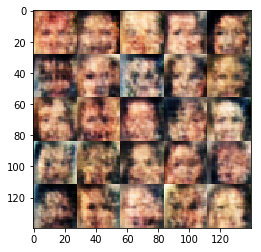

Epoch 1/1... Generator Loss: 0.9168 Discriminator Loss: 1.3355...
Epoch 1/1... Generator Loss: 0.8995 Discriminator Loss: 1.3718...
Epoch 1/1... Generator Loss: 0.8688 Discriminator Loss: 1.4147...
Epoch 1/1... Generator Loss: 0.8474 Discriminator Loss: 1.4077...
Epoch 1/1... Generator Loss: 0.8160 Discriminator Loss: 1.3815...
Epoch 1/1... Generator Loss: 0.8122 Discriminator Loss: 1.3649...
Epoch 1/1... Generator Loss: 0.7776 Discriminator Loss: 1.4264...
Epoch 1/1... Generator Loss: 0.8871 Discriminator Loss: 1.2917...
Epoch 1/1... Generator Loss: 0.8100 Discriminator Loss: 1.3563...
Epoch 1/1... Generator Loss: 0.8343 Discriminator Loss: 1.4178...


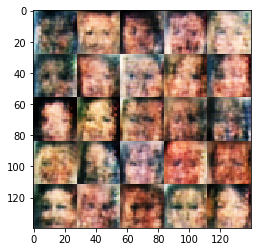

Epoch 1/1... Generator Loss: 0.8438 Discriminator Loss: 1.3901...
Epoch 1/1... Generator Loss: 0.8046 Discriminator Loss: 1.3414...
Epoch 1/1... Generator Loss: 0.8122 Discriminator Loss: 1.3527...
Epoch 1/1... Generator Loss: 0.7781 Discriminator Loss: 1.3812...
Epoch 1/1... Generator Loss: 0.7708 Discriminator Loss: 1.4075...
Epoch 1/1... Generator Loss: 0.9081 Discriminator Loss: 1.3953...
Epoch 1/1... Generator Loss: 1.1789 Discriminator Loss: 1.4122...
Epoch 1/1... Generator Loss: 0.7475 Discriminator Loss: 1.3819...
Epoch 1/1... Generator Loss: 0.7297 Discriminator Loss: 1.3772...
Epoch 1/1... Generator Loss: 0.7629 Discriminator Loss: 1.3682...


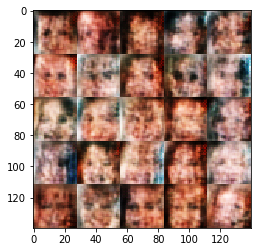

Epoch 1/1... Generator Loss: 0.7541 Discriminator Loss: 1.4059...
Epoch 1/1... Generator Loss: 0.8090 Discriminator Loss: 1.4492...
Epoch 1/1... Generator Loss: 0.7724 Discriminator Loss: 1.3977...
Epoch 1/1... Generator Loss: 0.8149 Discriminator Loss: 1.3868...
Epoch 1/1... Generator Loss: 0.8324 Discriminator Loss: 1.4009...
Epoch 1/1... Generator Loss: 0.7045 Discriminator Loss: 1.4429...
Epoch 1/1... Generator Loss: 0.7308 Discriminator Loss: 1.4207...
Epoch 1/1... Generator Loss: 0.7988 Discriminator Loss: 1.4211...
Epoch 1/1... Generator Loss: 0.8036 Discriminator Loss: 1.3682...
Epoch 1/1... Generator Loss: 0.7949 Discriminator Loss: 1.3948...


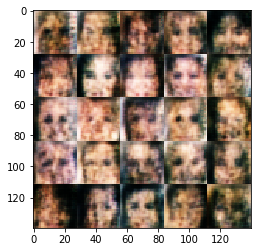

Epoch 1/1... Generator Loss: 0.9187 Discriminator Loss: 1.3851...
Epoch 1/1... Generator Loss: 0.8311 Discriminator Loss: 1.3975...
Epoch 1/1... Generator Loss: 0.8137 Discriminator Loss: 1.3795...
Epoch 1/1... Generator Loss: 0.8119 Discriminator Loss: 1.4342...
Epoch 1/1... Generator Loss: 0.7047 Discriminator Loss: 1.3539...
Epoch 1/1... Generator Loss: 0.7974 Discriminator Loss: 1.3364...
Epoch 1/1... Generator Loss: 0.7708 Discriminator Loss: 1.3542...
Epoch 1/1... Generator Loss: 0.8635 Discriminator Loss: 1.4112...
Epoch 1/1... Generator Loss: 0.7989 Discriminator Loss: 1.3731...
Epoch 1/1... Generator Loss: 0.7005 Discriminator Loss: 1.4975...


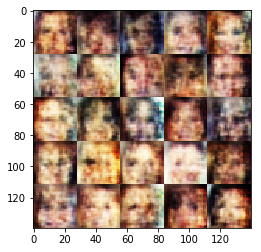

Epoch 1/1... Generator Loss: 0.7530 Discriminator Loss: 1.3785...
Epoch 1/1... Generator Loss: 0.8499 Discriminator Loss: 1.4385...
Epoch 1/1... Generator Loss: 0.9027 Discriminator Loss: 1.4010...
Epoch 1/1... Generator Loss: 0.7277 Discriminator Loss: 1.4701...
Epoch 1/1... Generator Loss: 0.8718 Discriminator Loss: 1.3596...
Epoch 1/1... Generator Loss: 0.8825 Discriminator Loss: 1.4287...
Epoch 1/1... Generator Loss: 0.7029 Discriminator Loss: 1.3893...
Epoch 1/1... Generator Loss: 0.6800 Discriminator Loss: 1.3783...
Epoch 1/1... Generator Loss: 0.7648 Discriminator Loss: 1.3704...
Epoch 1/1... Generator Loss: 0.8614 Discriminator Loss: 1.3556...


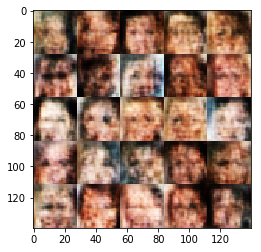

Epoch 1/1... Generator Loss: 0.8458 Discriminator Loss: 1.3555...
Epoch 1/1... Generator Loss: 0.7121 Discriminator Loss: 1.4530...
Epoch 1/1... Generator Loss: 0.7520 Discriminator Loss: 1.3916...
Epoch 1/1... Generator Loss: 0.8678 Discriminator Loss: 1.3253...
Epoch 1/1... Generator Loss: 0.7726 Discriminator Loss: 1.3924...
Epoch 1/1... Generator Loss: 0.7775 Discriminator Loss: 1.3105...
Epoch 1/1... Generator Loss: 0.7895 Discriminator Loss: 1.3419...
Epoch 1/1... Generator Loss: 0.8594 Discriminator Loss: 1.3749...
Epoch 1/1... Generator Loss: 0.8162 Discriminator Loss: 1.3621...
Epoch 1/1... Generator Loss: 0.7870 Discriminator Loss: 1.4766...


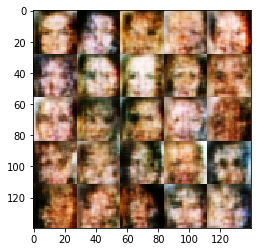

Epoch 1/1... Generator Loss: 0.7457 Discriminator Loss: 1.3998...
Epoch 1/1... Generator Loss: 0.8509 Discriminator Loss: 1.4182...
Epoch 1/1... Generator Loss: 0.7823 Discriminator Loss: 1.3895...
Epoch 1/1... Generator Loss: 0.8098 Discriminator Loss: 1.4233...
Epoch 1/1... Generator Loss: 0.9001 Discriminator Loss: 1.2734...
Epoch 1/1... Generator Loss: 0.8093 Discriminator Loss: 1.3444...
Epoch 1/1... Generator Loss: 0.7547 Discriminator Loss: 1.4369...
Epoch 1/1... Generator Loss: 0.8138 Discriminator Loss: 1.4120...
Epoch 1/1... Generator Loss: 0.7292 Discriminator Loss: 1.3677...
Epoch 1/1... Generator Loss: 0.9209 Discriminator Loss: 1.3693...


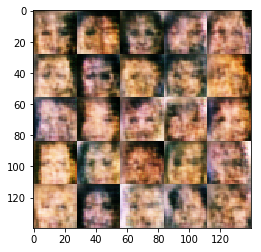

Epoch 1/1... Generator Loss: 0.8736 Discriminator Loss: 1.4159...
Epoch 1/1... Generator Loss: 0.8860 Discriminator Loss: 1.3189...
Epoch 1/1... Generator Loss: 0.7970 Discriminator Loss: 1.3753...
Epoch 1/1... Generator Loss: 0.8159 Discriminator Loss: 1.3704...
Epoch 1/1... Generator Loss: 0.7720 Discriminator Loss: 1.3608...
Epoch 1/1... Generator Loss: 0.8741 Discriminator Loss: 1.3851...
Epoch 1/1... Generator Loss: 0.7783 Discriminator Loss: 1.3087...
Epoch 1/1... Generator Loss: 0.7267 Discriminator Loss: 1.3478...
Epoch 1/1... Generator Loss: 0.8522 Discriminator Loss: 1.3485...
Epoch 1/1... Generator Loss: 0.8521 Discriminator Loss: 1.3324...


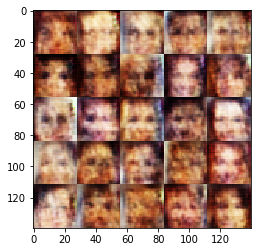

Epoch 1/1... Generator Loss: 0.8789 Discriminator Loss: 1.3681...
Epoch 1/1... Generator Loss: 0.6879 Discriminator Loss: 1.3944...
Epoch 1/1... Generator Loss: 0.7693 Discriminator Loss: 1.3728...
Epoch 1/1... Generator Loss: 0.8295 Discriminator Loss: 1.3766...
Epoch 1/1... Generator Loss: 0.7743 Discriminator Loss: 1.3859...
Epoch 1/1... Generator Loss: 0.8205 Discriminator Loss: 1.3729...
Epoch 1/1... Generator Loss: 0.8079 Discriminator Loss: 1.4095...
Epoch 1/1... Generator Loss: 0.8540 Discriminator Loss: 1.4223...
Epoch 1/1... Generator Loss: 0.8895 Discriminator Loss: 1.3520...
Epoch 1/1... Generator Loss: 0.8587 Discriminator Loss: 1.3580...


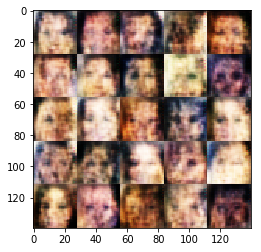

Epoch 1/1... Generator Loss: 0.8442 Discriminator Loss: 1.3974...
Epoch 1/1... Generator Loss: 0.7511 Discriminator Loss: 1.4263...
Epoch 1/1... Generator Loss: 0.8003 Discriminator Loss: 1.3941...
Epoch 1/1... Generator Loss: 0.8725 Discriminator Loss: 1.3772...
Epoch 1/1... Generator Loss: 0.8609 Discriminator Loss: 1.3571...
Epoch 1/1... Generator Loss: 0.8156 Discriminator Loss: 1.3655...
Epoch 1/1... Generator Loss: 0.8434 Discriminator Loss: 1.3997...
Epoch 1/1... Generator Loss: 0.8083 Discriminator Loss: 1.3859...
Epoch 1/1... Generator Loss: 0.7334 Discriminator Loss: 1.3847...
Epoch 1/1... Generator Loss: 0.7898 Discriminator Loss: 1.3750...


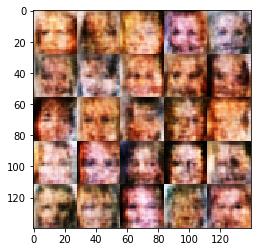

Epoch 1/1... Generator Loss: 0.7543 Discriminator Loss: 1.3728...
Epoch 1/1... Generator Loss: 0.7251 Discriminator Loss: 1.3626...
Epoch 1/1... Generator Loss: 0.7698 Discriminator Loss: 1.3867...
Epoch 1/1... Generator Loss: 0.7779 Discriminator Loss: 1.3610...
Epoch 1/1... Generator Loss: 0.8270 Discriminator Loss: 1.3677...
Epoch 1/1... Generator Loss: 0.8853 Discriminator Loss: 1.3746...
Epoch 1/1... Generator Loss: 0.8260 Discriminator Loss: 1.3602...
Epoch 1/1... Generator Loss: 0.8332 Discriminator Loss: 1.3371...
Epoch 1/1... Generator Loss: 0.8185 Discriminator Loss: 1.3387...
Epoch 1/1... Generator Loss: 0.7566 Discriminator Loss: 1.4088...


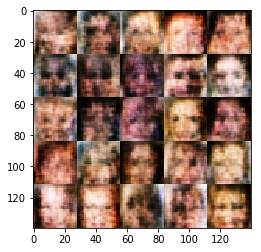

Epoch 1/1... Generator Loss: 0.7896 Discriminator Loss: 1.4062...
Epoch 1/1... Generator Loss: 0.7806 Discriminator Loss: 1.4328...
Epoch 1/1... Generator Loss: 0.7778 Discriminator Loss: 1.4074...
Epoch 1/1... Generator Loss: 0.9300 Discriminator Loss: 1.3470...
Epoch 1/1... Generator Loss: 0.7979 Discriminator Loss: 1.3805...
Epoch 1/1... Generator Loss: 0.7655 Discriminator Loss: 1.3938...
Epoch 1/1... Generator Loss: 0.8037 Discriminator Loss: 1.3588...
Epoch 1/1... Generator Loss: 0.6757 Discriminator Loss: 1.3930...
Epoch 1/1... Generator Loss: 0.8680 Discriminator Loss: 1.3309...
Epoch 1/1... Generator Loss: 0.8616 Discriminator Loss: 1.3452...


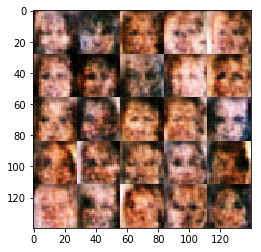

Epoch 1/1... Generator Loss: 0.8472 Discriminator Loss: 1.3415...
Epoch 1/1... Generator Loss: 0.7698 Discriminator Loss: 1.4070...
Epoch 1/1... Generator Loss: 0.8054 Discriminator Loss: 1.3763...
Epoch 1/1... Generator Loss: 0.7780 Discriminator Loss: 1.3856...
Epoch 1/1... Generator Loss: 0.8578 Discriminator Loss: 1.3761...
Epoch 1/1... Generator Loss: 0.7782 Discriminator Loss: 1.4198...
Epoch 1/1... Generator Loss: 0.7430 Discriminator Loss: 1.4008...
Epoch 1/1... Generator Loss: 0.7966 Discriminator Loss: 1.3759...
Epoch 1/1... Generator Loss: 0.8734 Discriminator Loss: 1.3922...
Epoch 1/1... Generator Loss: 0.7607 Discriminator Loss: 1.3887...


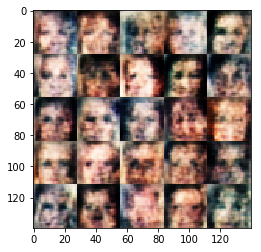

Epoch 1/1... Generator Loss: 0.7612 Discriminator Loss: 1.4023...
Epoch 1/1... Generator Loss: 0.8183 Discriminator Loss: 1.3461...
Epoch 1/1... Generator Loss: 0.7634 Discriminator Loss: 1.4330...
Epoch 1/1... Generator Loss: 0.7289 Discriminator Loss: 1.4152...
Epoch 1/1... Generator Loss: 0.8430 Discriminator Loss: 1.3870...
Epoch 1/1... Generator Loss: 0.8427 Discriminator Loss: 1.3917...
Epoch 1/1... Generator Loss: 0.8244 Discriminator Loss: 1.3739...
Epoch 1/1... Generator Loss: 0.7598 Discriminator Loss: 1.3690...
Epoch 1/1... Generator Loss: 0.7730 Discriminator Loss: 1.3897...
Epoch 1/1... Generator Loss: 0.7471 Discriminator Loss: 1.4293...


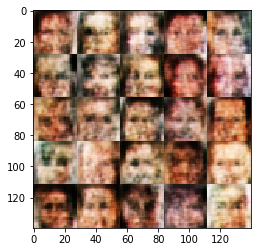

Epoch 1/1... Generator Loss: 0.7706 Discriminator Loss: 1.3773...
Epoch 1/1... Generator Loss: 0.7635 Discriminator Loss: 1.3924...
Epoch 1/1... Generator Loss: 0.8932 Discriminator Loss: 1.3764...
Epoch 1/1... Generator Loss: 0.8375 Discriminator Loss: 1.3358...
Epoch 1/1... Generator Loss: 0.8161 Discriminator Loss: 1.3338...
Epoch 1/1... Generator Loss: 0.7715 Discriminator Loss: 1.3335...
Epoch 1/1... Generator Loss: 0.7543 Discriminator Loss: 1.4168...
Epoch 1/1... Generator Loss: 0.8250 Discriminator Loss: 1.3914...
Epoch 1/1... Generator Loss: 0.8462 Discriminator Loss: 1.3447...
Epoch 1/1... Generator Loss: 0.7617 Discriminator Loss: 1.4293...


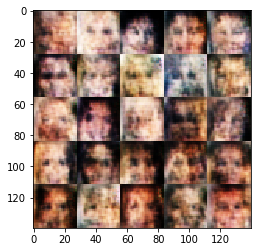

Epoch 1/1... Generator Loss: 0.8145 Discriminator Loss: 1.3984...
Epoch 1/1... Generator Loss: 0.8271 Discriminator Loss: 1.3578...
Epoch 1/1... Generator Loss: 0.8375 Discriminator Loss: 1.3773...
Epoch 1/1... Generator Loss: 0.8380 Discriminator Loss: 1.3786...
Epoch 1/1... Generator Loss: 0.8253 Discriminator Loss: 1.4222...
Epoch 1/1... Generator Loss: 0.8343 Discriminator Loss: 1.3637...
Epoch 1/1... Generator Loss: 0.7790 Discriminator Loss: 1.3762...
Epoch 1/1... Generator Loss: 0.7751 Discriminator Loss: 1.4025...
Epoch 1/1... Generator Loss: 0.8005 Discriminator Loss: 1.4315...
Epoch 1/1... Generator Loss: 0.8854 Discriminator Loss: 1.3573...


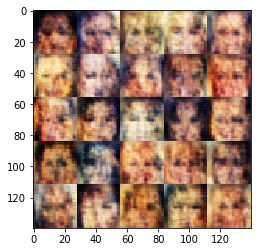

Epoch 1/1... Generator Loss: 0.8231 Discriminator Loss: 1.3963...
Epoch 1/1... Generator Loss: 0.8306 Discriminator Loss: 1.4330...
Epoch 1/1... Generator Loss: 0.7725 Discriminator Loss: 1.3736...
Epoch 1/1... Generator Loss: 0.7648 Discriminator Loss: 1.3613...
Epoch 1/1... Generator Loss: 0.8366 Discriminator Loss: 1.3870...
Epoch 1/1... Generator Loss: 0.7914 Discriminator Loss: 1.3697...
Epoch 1/1... Generator Loss: 0.8594 Discriminator Loss: 1.3148...
Epoch 1/1... Generator Loss: 0.6755 Discriminator Loss: 1.3971...
Epoch 1/1... Generator Loss: 0.8371 Discriminator Loss: 1.3398...
Epoch 1/1... Generator Loss: 0.8120 Discriminator Loss: 1.3515...


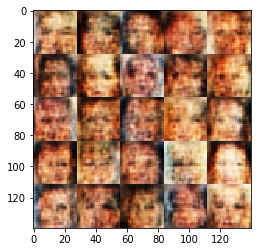

Epoch 1/1... Generator Loss: 0.9059 Discriminator Loss: 1.3971...
Epoch 1/1... Generator Loss: 0.8490 Discriminator Loss: 1.4126...
Epoch 1/1... Generator Loss: 0.7595 Discriminator Loss: 1.4177...
Epoch 1/1... Generator Loss: 0.7123 Discriminator Loss: 1.3466...
Epoch 1/1... Generator Loss: 0.8268 Discriminator Loss: 1.3760...
Epoch 1/1... Generator Loss: 0.7996 Discriminator Loss: 1.3593...
Epoch 1/1... Generator Loss: 0.7862 Discriminator Loss: 1.4311...
Epoch 1/1... Generator Loss: 0.8432 Discriminator Loss: 1.4360...
Epoch 1/1... Generator Loss: 0.7332 Discriminator Loss: 1.3967...
Epoch 1/1... Generator Loss: 0.7242 Discriminator Loss: 1.3601...


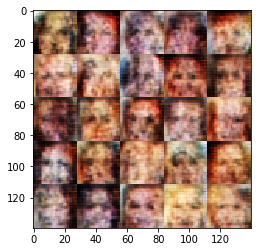

Epoch 1/1... Generator Loss: 0.7482 Discriminator Loss: 1.3498...
Epoch 1/1... Generator Loss: 0.8444 Discriminator Loss: 1.4227...
Epoch 1/1... Generator Loss: 0.7681 Discriminator Loss: 1.3706...
Epoch 1/1... Generator Loss: 0.8028 Discriminator Loss: 1.3691...
Epoch 1/1... Generator Loss: 0.7409 Discriminator Loss: 1.3382...
Epoch 1/1... Generator Loss: 0.8244 Discriminator Loss: 1.3450...
Epoch 1/1... Generator Loss: 0.8060 Discriminator Loss: 1.3637...
Epoch 1/1... Generator Loss: 0.8197 Discriminator Loss: 1.3407...
Epoch 1/1... Generator Loss: 0.8942 Discriminator Loss: 1.3513...
Epoch 1/1... Generator Loss: 0.7979 Discriminator Loss: 1.3801...


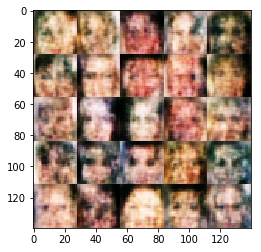

Epoch 1/1... Generator Loss: 0.8382 Discriminator Loss: 1.4040...
Epoch 1/1... Generator Loss: 0.8421 Discriminator Loss: 1.3663...
Epoch 1/1... Generator Loss: 0.8101 Discriminator Loss: 1.4166...
Epoch 1/1... Generator Loss: 0.7245 Discriminator Loss: 1.3852...
Epoch 1/1... Generator Loss: 0.8053 Discriminator Loss: 1.3526...
Epoch 1/1... Generator Loss: 0.7589 Discriminator Loss: 1.3923...
Epoch 1/1... Generator Loss: 0.8212 Discriminator Loss: 1.4081...
Epoch 1/1... Generator Loss: 0.8354 Discriminator Loss: 1.3766...
Epoch 1/1... Generator Loss: 0.8004 Discriminator Loss: 1.3769...
Epoch 1/1... Generator Loss: 0.7650 Discriminator Loss: 1.3503...


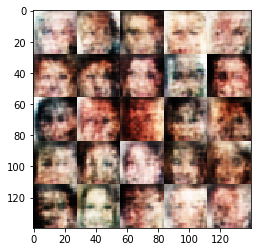

Epoch 1/1... Generator Loss: 0.8042 Discriminator Loss: 1.3494...
Epoch 1/1... Generator Loss: 0.7840 Discriminator Loss: 1.3716...
Epoch 1/1... Generator Loss: 0.7627 Discriminator Loss: 1.4099...
Epoch 1/1... Generator Loss: 0.7923 Discriminator Loss: 1.3952...
Epoch 1/1... Generator Loss: 0.7915 Discriminator Loss: 1.4043...
Epoch 1/1... Generator Loss: 0.8642 Discriminator Loss: 1.3603...
Epoch 1/1... Generator Loss: 0.7691 Discriminator Loss: 1.3831...
Epoch 1/1... Generator Loss: 0.7735 Discriminator Loss: 1.3930...
Epoch 1/1... Generator Loss: 0.8130 Discriminator Loss: 1.3741...
Epoch 1/1... Generator Loss: 0.8300 Discriminator Loss: 1.3657...


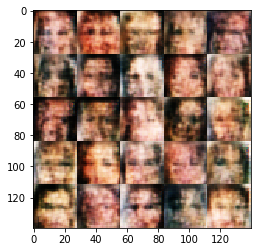

Epoch 1/1... Generator Loss: 0.7713 Discriminator Loss: 1.4028...
Epoch 1/1... Generator Loss: 0.8142 Discriminator Loss: 1.3632...
Epoch 1/1... Generator Loss: 0.8120 Discriminator Loss: 1.3860...
Epoch 1/1... Generator Loss: 0.8731 Discriminator Loss: 1.3690...
Epoch 1/1... Generator Loss: 0.7359 Discriminator Loss: 1.3813...
Epoch 1/1... Generator Loss: 0.8580 Discriminator Loss: 1.3903...
Epoch 1/1... Generator Loss: 0.8021 Discriminator Loss: 1.3969...
Epoch 1/1... Generator Loss: 0.8271 Discriminator Loss: 1.3968...
Epoch 1/1... Generator Loss: 0.7931 Discriminator Loss: 1.4448...
Epoch 1/1... Generator Loss: 0.7901 Discriminator Loss: 1.3619...


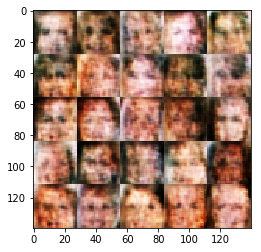

Epoch 1/1... Generator Loss: 0.7761 Discriminator Loss: 1.3715...
Epoch 1/1... Generator Loss: 0.7841 Discriminator Loss: 1.3790...
Epoch 1/1... Generator Loss: 0.8094 Discriminator Loss: 1.3869...
Epoch 1/1... Generator Loss: 0.8865 Discriminator Loss: 1.4024...
Epoch 1/1... Generator Loss: 0.7866 Discriminator Loss: 1.3970...
Epoch 1/1... Generator Loss: 0.7967 Discriminator Loss: 1.3780...
Epoch 1/1... Generator Loss: 0.8891 Discriminator Loss: 1.3419...
Epoch 1/1... Generator Loss: 0.8150 Discriminator Loss: 1.3511...
Epoch 1/1... Generator Loss: 0.8329 Discriminator Loss: 1.3511...
Epoch 1/1... Generator Loss: 0.8471 Discriminator Loss: 1.3044...


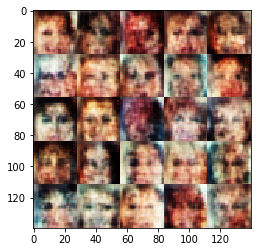

Epoch 1/1... Generator Loss: 0.8086 Discriminator Loss: 1.3967...
Epoch 1/1... Generator Loss: 0.8141 Discriminator Loss: 1.3816...
Epoch 1/1... Generator Loss: 0.7821 Discriminator Loss: 1.3411...
Epoch 1/1... Generator Loss: 0.7201 Discriminator Loss: 1.4575...
Epoch 1/1... Generator Loss: 0.8088 Discriminator Loss: 1.3772...
Epoch 1/1... Generator Loss: 0.8234 Discriminator Loss: 1.3912...
Epoch 1/1... Generator Loss: 0.8136 Discriminator Loss: 1.3829...
Epoch 1/1... Generator Loss: 0.8090 Discriminator Loss: 1.4109...
Epoch 1/1... Generator Loss: 0.7772 Discriminator Loss: 1.3743...
Epoch 1/1... Generator Loss: 0.7666 Discriminator Loss: 1.3986...


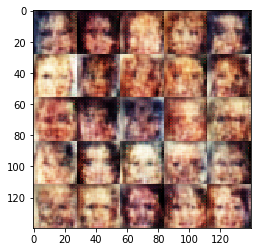

Epoch 1/1... Generator Loss: 0.8308 Discriminator Loss: 1.4252...
Epoch 1/1... Generator Loss: 0.8058 Discriminator Loss: 1.4081...
Epoch 1/1... Generator Loss: 0.7679 Discriminator Loss: 1.3599...
Epoch 1/1... Generator Loss: 0.8733 Discriminator Loss: 1.3647...
Epoch 1/1... Generator Loss: 0.8048 Discriminator Loss: 1.3850...
Epoch 1/1... Generator Loss: 0.7993 Discriminator Loss: 1.4062...
Epoch 1/1... Generator Loss: 0.7975 Discriminator Loss: 1.4134...
Epoch 1/1... Generator Loss: 0.8645 Discriminator Loss: 1.3700...
Epoch 1/1... Generator Loss: 0.7691 Discriminator Loss: 1.3668...
Epoch 1/1... Generator Loss: 0.7900 Discriminator Loss: 1.3972...


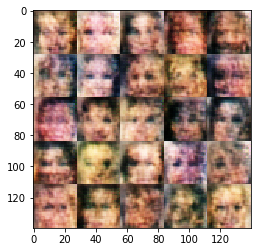

Epoch 1/1... Generator Loss: 0.8427 Discriminator Loss: 1.3364...
Epoch 1/1... Generator Loss: 0.7894 Discriminator Loss: 1.3614...
Epoch 1/1... Generator Loss: 0.8077 Discriminator Loss: 1.3745...
Epoch 1/1... Generator Loss: 0.8112 Discriminator Loss: 1.3661...
Epoch 1/1... Generator Loss: 0.7479 Discriminator Loss: 1.3681...
Epoch 1/1... Generator Loss: 0.8276 Discriminator Loss: 1.3756...
Epoch 1/1... Generator Loss: 0.7965 Discriminator Loss: 1.3361...
Epoch 1/1... Generator Loss: 0.7348 Discriminator Loss: 1.3930...
Epoch 1/1... Generator Loss: 0.8120 Discriminator Loss: 1.4051...
Epoch 1/1... Generator Loss: 0.8183 Discriminator Loss: 1.3851...


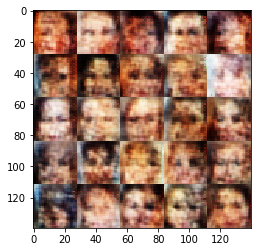

Epoch 1/1... Generator Loss: 0.7960 Discriminator Loss: 1.3785...
Epoch 1/1... Generator Loss: 0.7702 Discriminator Loss: 1.3580...
Epoch 1/1... Generator Loss: 0.8323 Discriminator Loss: 1.3849...
Epoch 1/1... Generator Loss: 0.8174 Discriminator Loss: 1.3738...
Epoch 1/1... Generator Loss: 0.8165 Discriminator Loss: 1.3578...
Epoch 1/1... Generator Loss: 0.7358 Discriminator Loss: 1.4163...
Epoch 1/1... Generator Loss: 0.8330 Discriminator Loss: 1.4107...
Epoch 1/1... Generator Loss: 0.8243 Discriminator Loss: 1.3663...
Epoch 1/1... Generator Loss: 0.8280 Discriminator Loss: 1.3973...
Epoch 1/1... Generator Loss: 0.8044 Discriminator Loss: 1.3709...


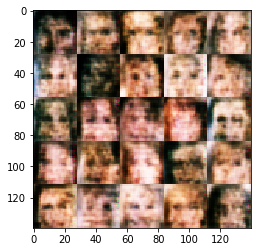

Epoch 1/1... Generator Loss: 0.7716 Discriminator Loss: 1.3870...
Epoch 1/1... Generator Loss: 0.8350 Discriminator Loss: 1.3458...
Epoch 1/1... Generator Loss: 0.7947 Discriminator Loss: 1.3632...
Epoch 1/1... Generator Loss: 0.8324 Discriminator Loss: 1.3868...
Epoch 1/1... Generator Loss: 0.8050 Discriminator Loss: 1.3457...
Epoch 1/1... Generator Loss: 0.8539 Discriminator Loss: 1.3882...
Epoch 1/1... Generator Loss: 0.8201 Discriminator Loss: 1.3756...
Epoch 1/1... Generator Loss: 0.7236 Discriminator Loss: 1.4118...
Epoch 1/1... Generator Loss: 0.7884 Discriminator Loss: 1.3869...
Epoch 1/1... Generator Loss: 0.8934 Discriminator Loss: 1.3366...


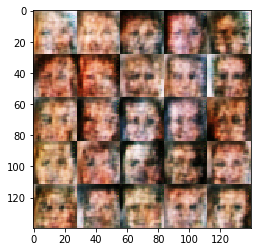

Epoch 1/1... Generator Loss: 0.7813 Discriminator Loss: 1.3816...
Epoch 1/1... Generator Loss: 0.7879 Discriminator Loss: 1.4077...
Epoch 1/1... Generator Loss: 0.7636 Discriminator Loss: 1.4236...
Epoch 1/1... Generator Loss: 0.7839 Discriminator Loss: 1.3699...
Epoch 1/1... Generator Loss: 0.8537 Discriminator Loss: 1.3639...
Epoch 1/1... Generator Loss: 0.7740 Discriminator Loss: 1.3678...
Epoch 1/1... Generator Loss: 0.8263 Discriminator Loss: 1.3536...
Epoch 1/1... Generator Loss: 0.7756 Discriminator Loss: 1.4293...
Epoch 1/1... Generator Loss: 0.8195 Discriminator Loss: 1.3690...
Epoch 1/1... Generator Loss: 0.7809 Discriminator Loss: 1.3729...


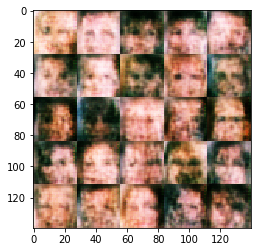

Epoch 1/1... Generator Loss: 0.8143 Discriminator Loss: 1.3899...
Epoch 1/1... Generator Loss: 0.8098 Discriminator Loss: 1.3948...
Epoch 1/1... Generator Loss: 0.7919 Discriminator Loss: 1.3806...
Epoch 1/1... Generator Loss: 0.7589 Discriminator Loss: 1.3638...
Epoch 1/1... Generator Loss: 0.8361 Discriminator Loss: 1.3725...
Epoch 1/1... Generator Loss: 0.8010 Discriminator Loss: 1.3753...
Epoch 1/1... Generator Loss: 0.7425 Discriminator Loss: 1.3946...
Epoch 1/1... Generator Loss: 0.7992 Discriminator Loss: 1.3880...
Epoch 1/1... Generator Loss: 0.7827 Discriminator Loss: 1.3926...
Epoch 1/1... Generator Loss: 0.7752 Discriminator Loss: 1.3943...


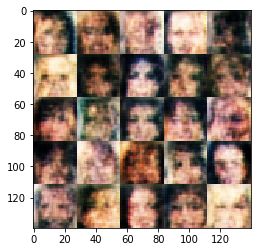

Epoch 1/1... Generator Loss: 0.7865 Discriminator Loss: 1.3875...
Epoch 1/1... Generator Loss: 0.8203 Discriminator Loss: 1.3724...
Epoch 1/1... Generator Loss: 0.8159 Discriminator Loss: 1.3509...
Epoch 1/1... Generator Loss: 0.8231 Discriminator Loss: 1.3644...
Epoch 1/1... Generator Loss: 0.8182 Discriminator Loss: 1.3646...
Epoch 1/1... Generator Loss: 0.7717 Discriminator Loss: 1.3589...
Epoch 1/1... Generator Loss: 0.8013 Discriminator Loss: 1.3773...
Epoch 1/1... Generator Loss: 0.7974 Discriminator Loss: 1.3917...
Epoch 1/1... Generator Loss: 0.7849 Discriminator Loss: 1.3931...
Epoch 1/1... Generator Loss: 0.8175 Discriminator Loss: 1.3803...


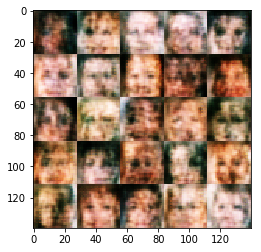

Epoch 1/1... Generator Loss: 0.7850 Discriminator Loss: 1.3830...
Epoch 1/1... Generator Loss: 0.7994 Discriminator Loss: 1.3959...
Epoch 1/1... Generator Loss: 0.7903 Discriminator Loss: 1.4018...


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.